In [5]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch
import h5py
import torchaudio
from torch.utils.data import random_split, Dataset, DataLoader
import torch.optim as optim
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from scipy.special import beta
from torch.special import psi
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Subset
import copy
import math
import wandb
import yaml
import time
import gc
import datetime
import optuna
import zarr
import seaborn as sns
from scipy import stats

if wandb.run is not None:
    wandb.run.tags = list(wandb.run.tags) + ["junk"]
wandb.finish()

In [6]:
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/wideband_twocarrier_3.1V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/wideband_single_carrier_3.5V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/wideband_2.83V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/time_channel_2.83V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/unnormalized_channel_2.83V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/unnormalized_channel_3.5V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/normalized_channel_2.83V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/single_X_3.5V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/unnormalized_wide_channel_3.5V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/unnormalized_wide_channel_3.5V_scale2.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/unnormalized_wide_channel_test_3.5V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/unnormalized_wide_channel_3.13V.h5"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/wide_channel_25MHz_3.5V_scale2.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/wide_channel_15MHz_3.5V_scale2.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/wide_channel_15MHz_3.5V_scale4.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/wide_channel_7.5MHz_3.5V_scale8.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/wide_channel_4MHz_3.5V_scale2.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/wide_channel_3e5-4MHz_3.5V_scale4.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/channel_3e5-4MHz_3.5V_scale2.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/channel_3e5-15MHz_3.5V_scale2.zarr"
# file_path = "C:/Users/maild/mldrivenpeled/data/channel_measurements/zarr_files/test/channel_3e5-15MHz_3.5V_scale2.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/channel_3e5-30MHz_3.5V_scale2.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/wide_channel_7.5MHz_3.5V_scale4.zarr"
# file_path = "/Users/dylanjones/Desktop/mldrivenpeled/data/channel_measurements/zarr_files/wide_channel_1e4-15MHz_3.5V_scale4.zarr"
file_path = "C:/Users/maild/mldrivenpeled/data/channel_measurements/zarr_files/channel_3e5-15MHz_2.8V_scale2_v2.zarr"


# Set device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device("mps") # for M chip Macs
else:
    device = torch.device("cpu")
print(device)


WIDE_BAND = False
TIME_MODEL = True

cache_path = file_path.replace(".zarr", "_cached.pt").replace(".h5", "_cached.pt")

if os.path.exists(cache_path):
    data = torch.load(cache_path, map_location=device)
    sent_frames_time = data["sent_frames_time"].to(device)
    received_frames_time_resampled = data["received_frames_time"].to(device)
    FREQUENCIES = data["frequencies"].to(device)
    NUM_POINTS_SYMBOL = data["NUM_POINTS_SYMBOL"]
    CP_LENGTH = data["CP_LENGTH"]
    delta_f = FREQUENCIES[1] - FREQUENCIES[0]
    KS = (FREQUENCIES / delta_f).to(torch.int)
    K_MIN = int(KS[0].item())
    K_MAX = int(KS[-1].item())
    NUM_ZEROS = K_MIN - 1
    CP_RATIO = 0.25
    NUM_POINTS_FRAME = NUM_POINTS_SYMBOL - CP_LENGTH
    NUM_POS_FREQS_LOW_BAND = K_MAX + 1
    print(NUM_POINTS_FRAME  - 2 * NUM_POS_FREQS_LOW_BAND)
    UPSAMPLING_ZEROS = (NUM_POINTS_FRAME  - 2 * NUM_POS_FREQS_LOW_BAND) // 2

    print("Loaded from cache!")
else:
    print("No cache found — loading original dataset...")


    H5 = False
    FREQUENCIES = None
    if H5:
        # Extract all frame data
        DTYPE = torch.complex64
        sent = []
        received = []
        received_time = []
        FREQUENCIES = None
        with h5py.File(file_path, "r") as f:
            # Get frequency
            first_frame = list(f.keys())[-1]
            FREQUENCIES = torch.tensor(f[first_frame]['freqs'][:], dtype=DTYPE).to(device).real
            NUM_POINTS_SYMBOL = int(f[first_frame]['num_points_symbol'][()])
            CP_LENGTH = int(f[first_frame]['cp_length'][()])
            for frame in f:
                group = f[frame]
                sent.append(torch.tensor(group['sent'][:], dtype=DTYPE))
                received.append(torch.tensor(group['received'][:], dtype=DTYPE))
                received_time.append(torch.tensor(group['received_time'][:], dtype=DTYPE))
    else:
        # Open the Zarr root
        root = zarr.open(file_path, mode="r")

        # Get first frame


        # Load metadata (attributes live under .attrs)
        sent, received, received_time = [], [], []

        # Loop through frames
        num_skipped = 0
        for frame_key in root.group_keys():
            try:
                frame = root[frame_key]
                if FREQUENCIES is None:
                    FREQUENCIES = torch.tensor(frame["freqs"][:], dtype=torch.int).real
                    NUM_POINTS_SYMBOL = int(frame.attrs["num_points_symbol"])
                    CP_LENGTH = int(frame.attrs["cp_length"])
                else:
                    pass

                sent.append(torch.tensor(frame["sent"][:], dtype=torch.complex64))
                received.append(torch.tensor(frame["received"][:], dtype=torch.complex64))
                if "received_time" in frame:
                    received_time.append(torch.tensor(frame["received_time"][:], dtype=torch.float32))
            except:
                num_skipped += 1
                pass # skip corrupted frames
        print(f"Skipped {num_skipped} corrupted frames")

    sent_frames = torch.stack(sent).squeeze(1)
    received_frames = torch.stack(received).squeeze(1)


    delta_f = FREQUENCIES[1] - FREQUENCIES[0]
    KS = (FREQUENCIES / delta_f).to(torch.int)
    K_MIN = int(KS[0].item())
    K_MAX = int(KS[-1].item())
    NUM_ZEROS = K_MIN - 1
    CP_RATIO = 0.25
    NUM_POINTS_FRAME = NUM_POINTS_SYMBOL - CP_LENGTH
    NUM_POS_FREQS_LOW_BAND = K_MAX + 1
    UPSAMPLING_ZEROS = (NUM_POINTS_FRAME  - 2 * NUM_POS_FREQS_LOW_BAND) // 2

    def normalize_inband_power(symbols_arr, inband_mask):
        freq = torch.fft.fft(symbols_arr, dim=1)
        freq_inband = freq[:, inband_mask]
        pow_inband = torch.mean(torch.abs(freq_inband) ** 2, dim=1, keepdim=True)
        scale = torch.sqrt(pow_inband)
        normalized = symbols_arr / scale
        return normalized

    def symbols_to_time(X, num_padding_zeros: int, num_leading_zeros=0):
        # Make hermetian symmetric
        Nt, Nf = X.shape
        padding_zeros = torch.zeros(Nt, num_padding_zeros, device=device)
        leading_zeros = torch.zeros(Nt, num_leading_zeros, device=device)
        X = torch.cat([leading_zeros, X.to(device), padding_zeros], dim=-1)
        DC_Nyquist = torch.zeros((X.shape[0], 1), device=X.device)
        X_hermitian = torch.flip(X, dims=[1]).conj()
        X_full = torch.hstack([DC_Nyquist, X, DC_Nyquist, X_hermitian])

        # Convert to time domain
        x_time = torch.fft.ifft(X_full, dim=-1, norm="ortho").real
        return x_time.to(device)

    if len(received_time) > 0:
        N_shortest = min(t.size(-1) for t in received_time)
        N_longest = max(t.size(-1) for t in received_time)
        good_indices = [i for i, x in enumerate(received_time) if x.size(-1) == N_shortest]
        received_frames_time = torch.stack([t for t in received_time if t.size(-1) == N_shortest], dim=0).real
        sent_frames = sent_frames[good_indices]


        received_frames_time = received_frames_time.squeeze(1)

    # print(f"Min length {N_shortest} | Max length {N_longest}")
    # print(np.unique_counts(np.array([t.size(1) for t in received_frames_time])))


    # Attach leading and following zeros if wideband

    DELAY_TIME = 0
    if TIME_MODEL:
        sent_frames_time = symbols_to_time(sent_frames, UPSAMPLING_ZEROS, NUM_ZEROS)
        # Add cyclic prefix
        sent_frames_time = torch.hstack((sent_frames_time[:, -CP_LENGTH:], sent_frames_time))
        if DELAY_TIME > 0:
            sent_frames_time = sent_frames_time[:, :-DELAY_TIME]
        print(sent_frames_time.shape)
        # sent_frames_time = sent_frames_time[:, 2:-2] # Trim last sample
        # received_frames_time_resampled = torchaudio.functional.resample(received_frames_time, orig_freq=received_frames_time.size(1), new_freq=sent_frames_time.size(1))
        # received_frames_time_resampled = received_frames_time[:, 2:-2] # Trim last sample
        received_frames_time_resampled = received_frames_time[:, DELAY_TIME:]
        received_frames_time_resampled = received_frames_time_resampled - received_frames_time_resampled.mean(dim=1, keepdim=True)
        # sent_frames_time -= sent_frames_time.min()

        sent_frames_time = sent_frames_time.to(device)
        received_frames_time_resampled = received_frames_time_resampled.to(device)




    # Create a cache path
    cache_path = file_path.replace(".zarr", "_cached.pt").replace(".h5", "_cached.pt")

    torch.save({
        "sent_frames_time": sent_frames_time.cpu(),
        "received_frames_time": received_frames_time_resampled.cpu(),
        "frequencies": FREQUENCIES.cpu(),
        "NUM_POINTS_SYMBOL": NUM_POINTS_SYMBOL,
        "CP_LENGTH": CP_LENGTH
    }, cache_path)

class ChannelData(Dataset):
        def __init__(self,
                    sent_frames,
                    received_frames,
                    frequencies,
                    transform=None,
                    target_transform=None):

            self.sent_frames = sent_frames
            self.received_frames = received_frames
            assert len(sent_frames) == len(received_frames)

        def __len__(self):
            return len(self.sent_frames)

        def __getitem__(self, idx):
            return self.sent_frames[idx], self.received_frames[idx]

if TIME_MODEL:
    dataset = ChannelData(sent_frames_time, received_frames_time_resampled, FREQUENCIES)
else:
    dataset = ChannelData(sent_frames, received_frames, FREQUENCIES)

# Split sizes
train_size = int(0.9 * len(dataset))

val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size  # ensures total = 100%

# Perform split
train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator()
)
print("Train Size", train_size)

cuda


C:\Users\maild\AppData\Local\Temp\ipykernel_31332\3208023016.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(cache_path, map_location=device)


3000
Loaded from cache!
Train Size 6202


In [7]:
sent_frames_time.shape

torch.Size([6892, 8000])

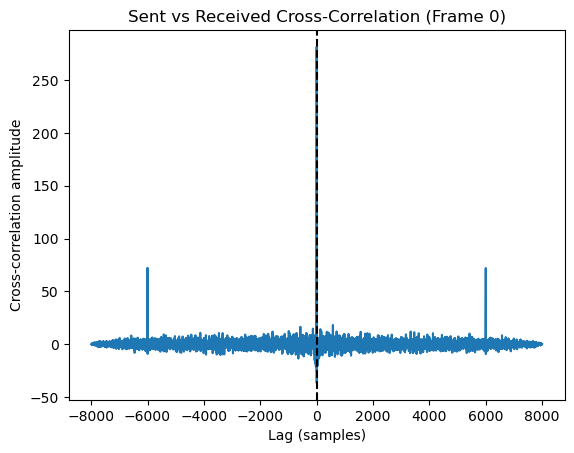

Peak lag: -1


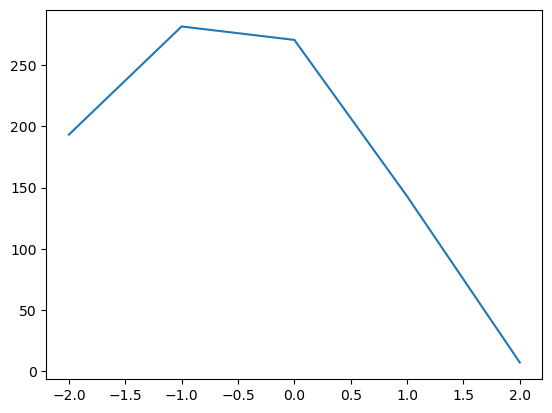

In [8]:
s = sent_frames_time[100].cpu().numpy()
r = received_frames_time_resampled[100].cpu().numpy()

corr = np.correlate(s, r, mode='full')
T = len(s)
zero_lag_index = T - 1

lags = np.arange(-T + 1, T)  # lag axis
plt.plot(lags, corr)
plt.axvline(0, color='k', linestyle='--')
plt.xlabel('Lag (samples)')
plt.ylabel('Cross-correlation amplitude')
plt.title('Sent vs Received Cross-Correlation (Frame 0)')
plt.show()

# Find best alignment
best_lag = lags[np.argmax(corr)]
print("Peak lag:", best_lag)

window = 2
lags = np.arange(-window, window + 1)
plt.plot(lags, corr[zero_lag_index - window:zero_lag_index + window + 1])

In [9]:
K_MIN

30

In [10]:
K_MAX

1499

In [11]:
K_MIN + len(KS)

1500

In [12]:
NUM_ZEROS

29

In [13]:
NUM_POINTS_FRAME

6000

In [14]:
CP_LENGTH

2000

In [15]:
NUM_POINTS_SYMBOL

8000

In [16]:
print(sent_frames_time.shape, received_frames_time_resampled.shape)

torch.Size([6892, 8000]) torch.Size([6892, 8000])


In [17]:
class ABC_time_model(nn.Module):
    def __init__(self, theta=None):
        super().__init__()
        if theta is None:
            self.theta = torch.nn.Parameter(torch.zeros(5))
        else:
            self.theta = theta
        self.last_n_traj = None


    def forward(self, x, return_n=True):
        # x: [B, T]
        B, T = x.shape
        device = x.device
        dtype = x.dtype
        n = torch.zeros(B, device=device, dtype=dtype)
        n_traj = torch.empty(B, T, device=device, dtype=dtype) if return_n else None
        outputs = torch.empty(B, T, device=device, dtype=dtype)
        theta0, theta1, theta2, theta3, theta4 = self.theta[0], self.theta[1], self.theta[2], self.theta[3], self.theta[4]
        for t in range(T):
            nsq = n * n
            n = (x[:, t] + theta0 * n + theta1 * nsq + theta2 * nsq * n)
            n = torch.tanh(n)
            outputs[:, t] = theta3 * n + theta4 * nsq
            assert not torch.isnan(n).any(), f"NaN detected at step {t}"
            if return_n:
                n_traj[:, t] = n
        self.last_n_traj = n_traj

        return outputs

class WarmupThenPlateau:
    """
    A learning rate scheduler that first performs a linear warmup for a given
    number of steps, and then hands over control to another scheduler (e.g., ReduceLROnPlateau).
    """
    def __init__(self, optimizer, warmup_steps, after_scheduler, target_lr):
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.after_scheduler = after_scheduler
        self.step_num = 0
        self.target_lr = target_lr

    def step(self, metrics=None):
        self.step_num += 1

        if self.step_num <= self.warmup_steps:
            # During the warmup phase, linearly increase the learning rate.
            lr_scale = self.step_num / self.warmup_steps
            for i, param_group in enumerate(self.optimizer.param_groups):
                param_group['lr'] = lr_scale * self.target_lr
        else:
            # On the first step after warmup, ensure the LR is set to the base value.
            # This creates a clean handoff to the after_scheduler.
            if self.step_num == self.warmup_steps + 1:
                for i, param_group in enumerate(self.optimizer.param_groups):
                    param_group['lr'] = self.target_lr

            # After the warmup, let the after_scheduler manage the LR.
            self.after_scheduler.step(metrics)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
        self.dtype = torch.float32

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, d_model]
        """
        # Add positional encoding to the input tensor
        x = x + self.pe[:x.size(1), :].transpose(0, 1)
        return x

class TimeSymbolEmbedding(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        # Input features: Real, Imag, Magnitude, Phase, Normalized Frequency Index
        self.linear = nn.Linear(2, d_model)
        self.d_model = d_model
        self.positional_encoding = PositionalEncoding(d_model, dropout=0, max_len=sent_frames_time.size(1))  # Create an instance

    def forward(self, x: torch.tensor) -> torch.tensor:
        # x shape: [Nt, 2Nf + 2, 2] (complex)
        x_power = x.square().unsqueeze(-1)
        x_combined = torch.cat([x.unsqueeze(-1), x_power], dim=-1)
        x = self.linear(x_combined) # [Nt, Nf, d_model]
        x = self.positional_encoding(x)
        return x # [Nt, Nf, d_model]


class PositionalEncoding(nn.Module):
    """Adds information about the position of each token in the sequence."""
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Args: x: Tensor, shape [batch_size, seq_len, embedding_dim]"""
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TimeEmbedding(nn.Module):
    """Embeds a 1D time-series input to a d_model dimension."""
    def __init__(self, d_model: int):
        super().__init__()
        self.embed = nn.Linear(1, d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.embed(x)

class TimeTransformer(nn.Module):
    def __init__(self,
                 d_model,
                 nhead,
                 nlayers,
                 dim_feedforward,
                 dropout):
        super().__init__()
        self.symbol_embed = TimeSymbolEmbedding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model,
                                                   nhead,
                                                   dim_feedforward=dim_feedforward,
                                                   batch_first=True,
                                                   dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, nlayers)
        self.output_unembed = nn.Linear(d_model, 1)

    def forward(self, x: torch.tensor) -> torch.tensor:
        x = self.symbol_embed(x) # [Nt, 2Nf + 2, d_model]
        x = self.transformer(x)
        x = self.output_unembed(x).squeeze(-1) # [Nt, 2Nf + 2] linear map
        return x # [Nt, 2Nf + 2]

class RecursiveTransformer(nn.Module):
    def __init__(self,
                 taps,
                 d_model,
                 nhead,
                 dim_feedforward,
                 nlayers,
                 dropout):
        super().__init__()
        self.taps = taps
        self.time_embed = TimeEmbedding(d_model)
        self.pos_embed = PositionalEncoding(d_model, max_len=taps)
        encoder_layer = nn.TransformerEncoderLayer(d_model,
                                                   nhead,
                                                   dim_feedforward=dim_feedforward,
                                                   batch_first=True,
                                                   dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, nlayers)
        self.output_unembed = nn.Linear(d_model, 1)


    def forward(self, x):
        # Pad input
        B, N = x.shape
        x_padded = F.pad(x, (self.taps - 1, 0))
        sliding_windows = x_padded.unfold(dimension=1, size=self.taps, step=1)
        sliding_windows_flat = sliding_windows.reshape(-1, self.taps)
        embedded_windows = self.time_embed(sliding_windows_flat.unsqueeze(-1))
        embedded_windows = self.pos_embed(embedded_windows)
        out_windows = self.transformer(embedded_windows)
        out = out_windows[:, -1, :] # [B, N, taps, dmodel] -> [B, N, dmodel]
        out = self.output_unembed(out) # [B, N, 1]
        out = out.reshape(B, N)
        out -= torch.mean(out, dim=-1, keepdim=True) # Remove DC bias
        return out

class RecursiveStateTransformer(nn.Module):
    def __init__(self,
                 taps,
                 d_model,
                 nhead,
                 dim_feedforward,
                 nlayers,
                 dropout,
                 state_size=1):
        super().__init__()
        self.taps = taps
        self.time_embed = TimeEmbedding(d_model)
        self.pos_embed = PositionalEncoding(d_model, max_len=taps + state_size)
        encoder_layer = nn.TransformerEncoderLayer(d_model,
                                                   nhead,
                                                   dim_feedforward=dim_feedforward,
                                                   batch_first=True,
                                                   dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, nlayers)
        self.output_unembed = nn.Linear(d_model, 1 + state_size)
        self.state_embed = nn.Linear(state_size, d_model)
        self.state_size = state_size

    def forward(self, x):
        B, N = x.shape
        device = x.device
        # Initialize the hidden state
        state = torch.zeros(B, self.state_size, device=device)
        outputs = []
        x_padded = F.pad(x, (self.taps - 1, 0))
        for t in range(N):
            window = x_padded[:, t:t+self.taps]
            embedded_window = self.time_embed(window.unsqueeze(-1)) # (B, taps, d_model)
            embedded_state = self.state_embed(state).unsqueeze(1) # (B, 1, d_model)
            transformer_input = torch.cat([embedded_window, embedded_state], dim=1) # (B, taps+1, d_model)
            positioned_input = self.pos_embed(transformer_input)
            transformer_out = self.transformer(positioned_input)
            feature_vector = transformer_out[:, -2, :] # (B, d_model)
            prediction_and_state = self.output_unembed(feature_vector)
            y_pred_t = prediction_and_state[:, 0]
            state = prediction_and_state[:, 1:]
            outputs.append(y_pred_t)
        out = torch.stack(outputs, dim=1)
        out -= torch.mean(out, dim=-1, keepdim=True) # Remove DC bias
        return out


class LearnableFrequencyNoise(nn.Module):
    def __init__(self, sequence_length: int):
        super().__init__()
        num_freq_bins = sequence_length // 2 + 1
        self.noise_psd = nn.Parameter(torch.zeros(num_freq_bins))

    def forward(self, x):
        batch_size, seq_len = x.shape
        noise_power = F.softplus(self.noise_psd)
        noise_amplitude = torch.sqrt(noise_power)
        noise_amplitude_batch = noise_amplitude.unsqueeze(0).expand(batch_size, -1)
        random_phase = torch.exp(1j * 2 * torch.pi * torch.rand_like(noise_amplitude_batch))
        noise_fft = noise_amplitude_batch * random_phase
        time_domain_noise = torch.fft.irfft(noise_fft, n=seq_len)
        return time_domain_noise

class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        self.conv = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            dilation=dilation,
            padding=0
        )
        self.padding = (kernel_size - 1) * dilation
        self.relu = nn.ReLU()
        self.resample = None
        if in_channels != out_channels:
            self.resample = nn.Conv1d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        out = F.pad(x, (self.padding, 0))
        out = self.conv(out)
        out = self.relu(out)
        if self.resample:
            x = self.resample(x)
        return out + x # residual connection


def sample_student_t_mps(mean, std, nu):
    '''
    Wilson-Hilferty Approximation for chi^2 converted to scaled and shifted student t
    '''
    z = torch.randn_like(mean)
    z_chi = torch.randn_like(mean)
    chi2_approx = nu * (1 - 2/(9*nu) + z_chi * torch.sqrt(2/(9*nu))).pow(3)
    scale = torch.sqrt(nu / (chi2_approx + 1e-6))
    return mean + std * z * scale


class TCN(nn.Module):
    def __init__(self, nlayers=3, dilation_base=2, num_taps=10, hidden_channels=32):
        super().__init__()
        layers = []
        in_channels = 1
        for i in range(nlayers):
            dilation = dilation_base ** i
            layers.append(
                TCNBlock(in_channels, hidden_channels, num_taps, dilation)
            )
            in_channels = hidden_channels
        self.tcn = nn.Sequential(*layers)
        self.readout = nn.Conv1d(hidden_channels, 1, kernel_size=1)

        # Calculate the total receptive field for the whole TCN stack
        self.receptive_field = 1
        for i in range(nlayers):
            dilation = dilation_base ** i
            self.receptive_field += (num_taps - 1) * dilation

    def forward(self, xin):
        x = xin.unsqueeze(1)    # [B,1,T]
        out = self.tcn(x)     # [B,H,T]
        out = self.readout(out).squeeze(1)
        out = out - out.mean(dim=1, keepdim=True)  # [B,T]
        return out


class NoiseInverter(nn.Module):
    def __init__(self, num_taps, hidden_size, state_size):
        super().__init__()

        self.state_map = nn.Sequential(
            nn.Linear(2 * num_taps + state_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, state_size)
        )

        self.state_out = nn.Sequential(
            nn.Linear(num_taps + state_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, 1)
        )
        self.num_taps = num_taps
        self.z0 = nn.Parameter(torch.zeros(state_size))

    def forward(self, xin, rin):
        B, T = xin.shape
        state = self.z0.expand(B, -1)
        x = F.pad(xin, (self.num_taps, 0))
        r = F.pad(rin, (self.num_taps, 0))
        out = torch.zeros_like(xin)
        for t in range(T):
            xt = x[:, t:t+self.num_taps]
            rt = r[:, t:t+self.num_taps]
            out[:, t] = self.state_out(torch.cat([xt, state], dim=-1)).squeeze(-1)
            state = state + self.state_map(torch.cat([xt, rt, state], dim=-1))
        return rin - out

class ARNoiseInverter(nn.Module):
    def __init__(self, p):
        super().__init__()

        self.weights = nn.Parameter(torch.zeros(p))
        self.p = p
        self.weights_fixed = torch.tensor([ 0.5012, -0.1166,  0.1292], device=device)

    def forward(self, r):
        kernel = torch.cat([-self.weights, torch.ones(1, device=device)]).view(1, 1, -1).to(device) # [B, p]
        r_padded = F.pad(r, (self.p, 0))
        out = F.conv1d(r_padded.unsqueeze(1), kernel, padding=0).squeeze(1)
        return out


class TCN_channel(nn.Module):
    def __init__(self, nlayers=3, dilation_base=2, num_taps=10, hidden_channels=32, learn_noise=False, gaussian=True):
        super().__init__()
        layers = []
        in_channels = 1
        for i in range(nlayers):
            dilation = dilation_base ** i
            layers.append(
                TCNBlock(in_channels, hidden_channels, num_taps, dilation)
            )
            in_channels = hidden_channels
        self.learn_noise = learn_noise
        self.tcn = nn.Sequential(*layers)
        if gaussian:
            self.readout = nn.Conv1d(hidden_channels, 2, kernel_size=1) # 2 channels mean | std
        else:
            self.readout = nn.Conv1d(hidden_channels, 3, kernel_size=1) # 3 channels mean | std | nu
        self.num_taps = num_taps
        self.gaussian = gaussian

        if not gaussian:
            with torch.no_grad():
                # Initialize log_nu bias
                self.readout.bias[2].fill_(48)

    def forward(self, xin):
        x = xin.unsqueeze(1)    # [B,1,T]
        # x = torch.cat([x, torch.square(x)], dim=1)
                # add y delayed
        out = self.tcn(x)     # [B,H,T]
        out = self.readout(out) # [B, 3, T] mean | std | nu
        mean_out = out[:, 0, :]
        log_std_out = out[:, 1, :]
        std_out = torch.exp(log_std_out)
        if not self.gaussian:
            log_nu_out = out[:, 2, :]
            nu_out = torch.nn.functional.softplus(log_nu_out)
            # nu_out = torch.exp(log_nu_out)
            nu_out = torch.clamp(nu_out, 2, 50) # nu between 2 and 50
        mean_out = mean_out - mean_out.mean(dim=1, keepdim=True)  # [B ,T]

        # # Produce noisy output
        if self.gaussian:
            z = torch.randn_like(mean_out)
            noisy_out = mean_out + std_out * z
            nu_out = torch.zeros_like(mean_out)
        else:
            noisy_out = sample_student_t_mps(mean_out, std_out, nu_out)
            
        if self.learn_noise:
            return noisy_out, mean_out, std_out, nu_out
        else:
            return mean_out, mean_out, torch.zeros_like(mean_out), torch.zeros_like(mean_out)


class CausalCNNChannel(nn.Module):
    def __init__(self, nlayers=4, hidden=32, kernel=13, gaussian=True, learn_noise=False):
        super().__init__()
        layers = []
        for i in range(nlayers):
            layers.append(nn.Conv1d(
                in_channels=1 if i==0 else hidden,
                out_channels=hidden,
                kernel_size=kernel,
                padding=kernel-1,   # temporary padding
            ))
            layers.append(nn.ReLU())
        self.net = nn.Sequential(*layers)

        self.gaussian = gaussian
        self.learn_noise = learn_noise
        self.readout = nn.Conv1d(hidden, 2 if gaussian else 3, kernel_size=1)

    def forward(self, xin):
        x = xin.unsqueeze(1)
        out = self.net(x)
        out = out[..., :xin.size(-1)]
        out = self.readout(out)
        mean = out[:,0]
        mean = mean - mean.mean(dim=1, keepdim=True)
        std = torch.exp(out[:,1])
        if self.gaussian:
            return mean, mean, std, torch.zeros_like(mean)
        else:
            nu = torch.nn.functional.softplus(out[:,2]) + 2
            noisy = sample_student_t_mps(mean, std, nu)
            return noisy, mean, std, nu


In [18]:
def compute_in_band_snr(y, y_pred, band_indices):
    y_freq = torch.fft.fft(y[CP_LENGTH:], norm="ortho")[band_indices]
    y_pred_freq = torch.fft.fft(y_pred[CP_LENGTH:], norm="ortho")[band_indices]
    noise_power = (y_freq - y_pred_freq).abs().pow(2)
    snr_est = (y_pred_freq.abs().pow(2)) / (noise_power)
    return snr_est.mean()

def visualize_std(model, input_tensor):
    model.eval()
    with torch.no_grad():
        noisy_sample, mean_pred, std_pred, _ = model(input_tensor)

    xin = input_tensor[0].cpu().numpy()
    mean = mean_pred[0].cpu().numpy()
    std = std_pred[0].cpu().numpy()
    sample = noisy_sample[0].cpu().numpy()

    time_steps = np.arange(len(xin))

    plt.figure(figsize=(14, 7))

    plt.plot(time_steps, mean, label='Predicted Mean', color='blue', linewidth=2)

    plt.fill_between(
        time_steps,
        mean - 2 * std,
        mean + 2 * std,
        color='blue',
        alpha=0.2,
        label='Uncertainty (±2σ)'
    )

    plt.plot(time_steps, sample, label='Generated Sample', color='green', alpha=0.7)

    plt.title('Model Prediction with Learned Uncertainty')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.show()

def compute_snr_loss_frequency_domain(y, y_pred_mean, noisy_y_pred, cp_length):
    """
    Compute SNR matching loss in frequency domain.

    Args:
        y: [batch, time] - true outputs
        y_pred_mean: [batch, time] - predicted means
        target_snr_per_freq: [num_freq_bins] - target SNR for each frequency
        cp_length: int - cyclic prefix length

    Returns:
        snr_loss: scalar
    """
    # Remove CP
    y_no_cp = y[:, cp_length:]
    noisy_y_pred_no_cp = noisy_y_pred[:, cp_length:]
    y_pred_no_cp = y_pred_mean[:, cp_length:]
    # Compute residuals
    predicted_noise = y_pred_no_cp - noisy_y_pred_no_cp
    approximate_exp_noise = y_no_cp - y_pred_no_cp.detach()

    # FFT to frequency domain
    y_freq = torch.fft.rfft(y_no_cp, dim=-1, norm='ortho')
    y_pred_freq = torch.fft.rfft(y_pred_no_cp, dim=-1, norm='ortho')
    predicted_noise_freq = torch.fft.rfft(predicted_noise, dim=-1, norm='ortho')
    approximate_exp_noise_freq = torch.fft.rfft(approximate_exp_noise, dim=-1, norm='ortho')

    # Power per frequency (average over batch)
    signal_power_model = y_pred_freq.abs().pow(2).mean(dim=0)
    signal_power_exp = y_freq.abs().pow(2).mean(dim=0)
    predicted_noise_power = predicted_noise_freq.abs().pow(2).mean(dim=0)
    approximate_exp_noise_power = approximate_exp_noise_freq.abs().pow(2).mean(dim=0)

    # Model's predicted SNR per frequency
    predicted_snr = signal_power_model / (predicted_noise_power + 1e-8)
    exp_snr = signal_power_exp / (approximate_exp_noise_power + 1e-8)

    # MSE loss
    snr_loss = F.mse_loss(predicted_snr, exp_snr)

    return snr_loss


def add_noise_floort(x, noise_std):
    noise = torch.randn_like(x) * noise_std
    return x + noise

In [19]:


CP_BUFFER = CP_LENGTH


def evm_loss(true_symbols, predicted_symbols):
    return torch.mean((torch.abs(true_symbols - predicted_symbols)) ** 2)


# def whiten_residuals(model, r, x):
#     phi1   = torch.tanh(model.ar_taps[0])
#     phi2  = torch.tanh(model.ar_taps[1])
#     phi3  = torch.tanh(model.ar_taps[2])
#     phi4  = torch.tanh(model.ar_taps[3])
#     psi   = model.input_taps[0]
#     psi2  = model.input_taps[1]
#     # beta1 = model.cross_tap
#     # beta2 = model.cross_tap_2
#     gamma1 = model.input_taps[2]
#     num_lag = 4
#     r_cur  = r[:, num_lag:]

#     '''
#     x1 x2
#     r1 r2
#     '''

#     z = (
#         r_cur
#         - phi1  * r[:, 3:-num_lag+3]
#         - phi2  * r[:, 2:-num_lag+2]
#         - phi3  * r[:, 1:-num_lag+1]
#         - phi4  * r[:, :-num_lag]
#         - psi   * r_cur * x[:, 3:-num_lag+3]
#         - psi2  * r_cur * x[:, 2:-num_lag+2]
#         - gamma1 * x[:, num_lag - 2:-2] ** 2
#         # - beta1 * (x_prev * r_prev)
#         # - beta2 * (x_cur  * r_prev)
#     )
#     return z

# def whiten_residuals(model, r, x):
#     phi1   = torch.tanh(model.ar_taps[0])
#     phi2  = torch.tanh(model.ar_taps[1])
#     phi3  = torch.tanh(model.ar_taps[2])
#     phi4  = torch.tanh(model.ar_taps[3])
#     psi   = model.input_taps[0]
#     psi2  = model.input_taps[1]
#     # beta1 = model.cross_tap
#     # beta2 = model.cross_tap_2
#     gamma1 = model.input_taps[2]
#     num_lag = 2
#     r_cur  = r[:, num_lag:]
#     x_cur = x[:, num_lag:]

#     '''
#     x1 x2
#     r1 r2
#     '''

#     z = (r_cur
#          - phi1 * r[:, 1:-1]
#          - phi2 * x[:, 1:-1] ** 2
#          - phi3 *(x_cur ** 2) * r[:, :-2]
#     )
#     return z



import torch
import torch.nn as nn
import torch.nn.functional as F

class ARXNoise(nn.Module):
    def __init__(self, p_r=3, p_x=2):
        super().__init__()
        self.p_r = p_r
        self.p_x = p_x

        # AR taps on residuals r_{t-i}
        self.ar_taps = nn.Parameter(torch.zeros(p_r))

        # Squared input taps x_{t-j}^2
        self.x2_taps = nn.Parameter(torch.zeros(p_x))

        # Cross taps r_t * x_{t-j}
        self.xr_taps = nn.Parameter(torch.zeros(p_x))

    def forward(self, x, r):
        """
        r: [B, T] residuals
        x: [B, T] inputs

        Returns z_full: [B, T] (same length as r), with first L samples zeroed.
        """
        B, T = r.shape
        device = r.device

        L = max(self.p_r, self.p_x)

        # Left pad
        r_pad = F.pad(r, (L, 0))
        x_pad = F.pad(x, (L, 0))

        # Collect residual lags r_{t-1}, ..., r_{t-p_r}
        if self.p_r > 0:
            r_lags = torch.stack(
                [r_pad[:, L - i : T + L - i] for i in range(1, self.p_r + 1)],
                dim=-1
            )  # [B, T, p_r]
            ar_part = (r_lags * self.ar_taps.view(1, 1, -1)).sum(dim=-1)  # [B, T]
        else:
            ar_part = 0.0

        # Collect input lags x_{t-1}, ..., x_{t-p_x}
        if self.p_x > 0:
            x_lags = torch.stack(
                [x_pad[:, L - j : T + L - j] for j in range(1, self.p_x + 1)],
                dim=-1
            )  # [B, T, p_x]


            # Squared input term
            x2_lags = x_lags ** 2
            x2_part = (x2_lags * self.x2_taps.view(1, 1, -1)).sum(dim=-1)  # [B, T]

            # Cross term r_t * x_{t-j}
            r_expanded = r.unsqueeze(-1)  # [B, T, 1]
            xr_part = (x_lags * r_expanded * self.xr_taps.view(1, 1, -1)).sum(dim=-1)  # [B, T]
        else:
            x_part = 0.0
            x2_part = 0.0
            xr_part = 0.0

        # Full-length output
        z_full = r - ar_part

        return z_full




def whiten_residuals(model, r, x):
    phi1 = torch.tanh(model.ar_taps[0])
    phi2 = torch.tanh(model.ar_taps[1])
    gamma2 = model.input_taps[2]
    gamma3 = model.input_taps[3]

    r_cur = r[:, 3:]
    z = (
        r_cur
        - phi1 * r[:, 2:-1]
        - phi2 * r[:, 1:-2]
        - gamma2 * (x[:, 1:-2] ** 2) * r[:, 2:-1]  # u_{t-2}
        - gamma3 * (x[:, :-3] ** 2) * r[:, 1:-2] # u_{t-3}
    )
    return z

def train(model, noise_model, optimizer, loss_fn, loop, scheduler, batches, mode, train_ABC=True, slice_length=10):
    model.train()
    total_loss = 0
    batch_count = 0
    thetas = []
    for batch in loop:
        x, y = batch[0], batch[1]
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        if train_ABC:
            y_pred = model(x)
        else:
            noisy_y_pred, y_pred, y_pred_std, y_pred_nu = model(x)
            # y_pred = model(x)
        # if train_ABC:
        #     y_pred = torch.clamp(y_pred, -1e2, 1e2)
        # LOSS_INDICES = slice(CP_BUFFER, None)
        # LOSS_INDICES = slice(model.num_taps, -model.num_taps)
        # LOSS_INDICES = slice(slice_length, -slice_length)
        # Include SNR vs Freq loss


        # calculate residuals
        r = y - y_pred

        # whiten residuals
        # r = r[:, 1:] - torch.tanh(model.ar_tap) * r[:, :-1] - torch.tanh(model.input_tap) * (x[:, 1:] - x[:, :-1])

        # r = whiten_residuals(model, r, x)

        # r = (r - r.mean(dim=1, keepdim=True)) / (r.std(dim=1, keepdim=True) + 1e-6)
        # if mode != 'channel_only':
        #     r = noise_model(x, r)

        # r = noise_model(x, r)

        # send through noise inverter
        # e_pred = noise_model(r)


        if train_ABC:
            loss = loss_fn(y, y_pred)
        elif model.learn_noise:
            if model.gaussian:
                loss = loss_fn(r, y_pred_std)
            else:
                loss = loss_fn(r, y_pred_std, y_pred_nu)
        else:
            loss = loss_fn(y, y_pred)

        mse_loss = evm_loss(y_pred, y)

        if train_ABC:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        wandb.log({"nnl_train_loss": loss.item()})
        wandb.log({"mse_train_loss": mse_loss.item()})
        lr = optimizer.param_groups[0]["lr"]
        wandb.log({"learning_rate": lr})
        batch_count += 1
        loop.set_postfix(loss=loss.item())
        if train_ABC:
            theta_i = model.theta.detach().cpu().clone()
            thetas.append(theta_i)
        if batch_count % 10 == 0 and train_ABC:
            with torch.no_grad():
                theta_array = torch.stack(thetas, dim=0).numpy()
                plt.figure(figsize=(8, 5))
                print(f"Theta: {model.theta.detach().cpu().clone()}")
                for i in range(theta_array.shape[1]):
                    plt.plot(theta_array[:, i], label=f"$\\theta_{i}$")
                plt.xlabel("Batch")
                plt.ylabel("Theta value")
                plt.title("Evolution of Thetas during Training")
                plt.legend()
                plt.grid(True)
                plt.show()
                plt.plot(model.last_n_traj[0].cpu()[:100].numpy())
                plt.xlabel("Batch")
                plt.ylabel("N value")
                plt.title("Evolution of N during Training")
                plt.legend()
                plt.grid(True)
                plt.show()

        if batches is not None:
            if batch_count > batches:
                break # early stop

    loop.close()
    avg_train_loss = total_loss / batch_count

def val(model, noise_model, loss_fn, val_loader, config, slice_length, train_abc):
    model.eval()
    val_loss = 0
    batch_count = 0
    snr_track = []
    y_preds = []
    std_preds = []
    nu_preds = []
    true_ys = []
    noisy_ys = []
    val_mse_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            noisy_y, mean_y, std_y, nu_y = model(x)
            y_preds.append(mean_y)
            std_preds.append(std_y)
            nu_preds.append(nu_y)
            true_ys.append(y)
            noisy_ys.append(noisy_y)
            # LOSS_INDICES = slice(CP_BUFFER, None)
            # LOSS_INDICES = slice(slice_length, -slice_length)
            # LOSS_INDICES = slice(model.num_taps, -model.num_taps)
            if model.learn_noise:
                if model.gaussian:
                    loss = loss_fn(y - mean_y, std_y) # Use mean for validation
                else:
                    loss = loss_fn(y - mean_y, std_y, nu_y) # Use mean for validation
            else:
                loss = loss_fn(y, mean_y)
            mse_loss = evm_loss(y, mean_y)
            val_mse_loss += mse_loss.item()
            val_loss += loss.item()
            batch_count += 1
    avg_val_loss = (val_loss / batch_count)
    avg_val_mse_loss = (val_mse_loss / batch_count)

    y_preds = torch.vstack(y_preds)
    std_preds = torch.vstack(std_preds)
    nu_preds = torch.vstack(nu_preds)
    true_ys = torch.vstack(true_ys)
    noisy_ys = torch.vstack(noisy_ys)


    noise_pred = noisy_ys - y_preds
    noise_power_pred_k = torch.fft.fft(noise_pred[:, CP_LENGTH:], norm='ortho', dim=-1).abs().square().mean(dim=0)
    signal_power_model = torch.fft.fft(y_preds[:, CP_LENGTH:], norm='ortho', dim=-1).abs().square().mean(dim=0)
    snr_k_model = (signal_power_model / (noise_power_pred_k + 1e-8))
    sample_rate = delta_f * NUM_POINTS_FRAME
    # snr_mag_exp = 10 * torch.log10(torch.abs(snr_k_exp) + 1e-8)
    snr_mag_model = 10 * torch.log10(torch.abs(snr_k_model) + 1e-8)
    freqs = torch.fft.fftfreq(len(snr_mag_model), d=1/sample_rate)
    half = len(freqs)//2
    freqs = freqs[:half]
    # snr_mag_exp = snr_mag_exp[:half]
    snr_mag_model = snr_mag_model[:half]


    fig, ax = plt.subplots(figsize=(8, 5))
    # ax.plot(freqs, snr_mag_exp.cpu(), lw=1.5, color="steelblue")
    ax.plot(freqs, snr_mag_model.cpu(), lw=1.5, color="orange")

    ax.set_title("SNR vs Frequency (Model)", fontsize=11)
    ax.set_xlabel("Frequency", fontsize=9)
    ax.set_ylabel("SNR Magnitude (dB)", fontsize=9)
    # ax.legend(["Experimental SNR", "Model SNR"], fontsize=9)
    ax.grid(True, linestyle='--', alpha=0.6)


    # # ---- Log to WandB ----
    wandb.log({"SNR_Frequency": wandb.Image(fig)})
    plt.close(fig)


    # Log both scalar and histogram
    wandb.log({
        'val_nll_loss': avg_val_loss,
        "avg_val_mse_loss": avg_val_mse_loss,
    })

    # print(f"Average Val Loss: {avg_val_loss:.2e}")

    # visualize_std(model, x[:, :200])
    return avg_val_loss

In [20]:
def students_t_loss(difference, y_pred_std, y_pred_nu):
    # nu = y_pred_nu.clamp_min(2.0)
    nu = y_pred_nu
    z_resid = (difference) / (y_pred_std)
    term1 = -1 * torch.lgamma((nu + 1) / 2) + 0.5 * torch.log(torch.pi * nu) + torch.lgamma(nu / 2) + torch.log(y_pred_std + 1e-8)
    term2 = ((nu + 1) / 2) * torch.log(1 + (1 / nu) * torch.square(z_resid) + 1e-8)
    loss = torch.mean(term1 + term2)
    if torch.isnan(loss):
        raise ValueError("NaN in loss")
    return loss

def gaussian_nll(difference, y_pred_std):
    term1 = 0.5 * torch.log(2 * torch.pi * (y_pred_std ** 2))
    term2 = 0.5 * torch.square((difference) / y_pred_std)
    loss = torch.mean(term1 + term2)
    if torch.isnan(loss):
        raise ValueError("NaN in loss")
    return loss

noise_model = None

def make_optimizer(mode):
    if mode == "channel_only":
        return optim.AdamW(
            list(channel_model.parameters()),
            lr=float(config.lr_channel),
            weight_decay=float(config.wd_channel)
        )

    elif mode == "noise_only":
        return optim.AdamW(
            list(noise_model.parameters()),
            lr=float(config.lr_noise),
            weight_decay=float(config.wd_noise)
        )

    elif mode == "joint":
        return optim.AdamW(
            list(channel_model.parameters()) +
            list(noise_model.parameters()),
            lr=float(config.lr_joint),
            weight_decay=float(config.wd_joint)
        )
    else:
        raise ValueError("Unknown mode")


script_dir = os.getcwd()
config_path = os.path.join(script_dir, "..", "offline_time_channel_config.yml")
with open(config_path, "r") as f:
    hyperparams = yaml.safe_load(f)

# Start Weights and Biases session
wandb.init(project="mldrivenpeled",
           config=hyperparams, tags=['channel_model'])
config = wandb.config

schedule = config.training_schedule


RECEPTIVE_FIELD = (1 + (config.num_taps - 1) * (config.dilation_base**config.nlayers - 1) // (config.dilation_base - 1))


print(f"WandB run info:")
print(f"  Name: {wandb.run.name}")
print(f"  ID: {wandb.run.id}")
print(f"  URL: {wandb.run.url}")
print("Chosen hyperparameters for this session:")
print(config)


# Create dataloader
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=config.batch_size, drop_last=False)
test_loader = DataLoader(test_dataset)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=config.batch_size, drop_last=False)



# channel_model = ABC_time_model()

channel_model = TCN_channel(
    nlayers=config.nlayers,
    dilation_base=config.dilation_base,
    num_taps=config.num_taps,
    hidden_channels=config.hidden_channels,
    learn_noise=config.learn_noise,
    gaussian=config.gaussian
).to(device)

# noise_model = TCN(
#     nlayers=config.nlayers,
#     dilation_base=config.dilation_base,
#     num_taps=config.num_taps,
#     hidden_channels=config.hidden_channels
# ).to(device)

# channel_model = TCN(
#     nlayers=config.nlayers,
#     dilation_base=config.dilation_base,
#     num_taps=config.num_taps,
#     hidden_channels=config.hidden_channels,
# ).to(device)

# noise_model = ARNoiseInverter(3).to(device)

# noise_model = NoiseInverter(
#     num_taps=4,
#     hidden_size=16,
#     state_size=2
# ).to(device)

# noise_model = ARXNoise(
#     p_r=6,
#     p_x=6
# ).to(device)

# channel_model = CausalCNNChannel(
#     nlayers=config.nlayers,
#     hidden=config.hidden_channels,
#     kernel=config.num_taps,
#     gaussian=config.gaussian,
#     learn_noise=config.learn_noise
# ).to(device)

initial_model_state = copy.deepcopy(channel_model.state_dict())

# optimizer = optim.AdamW(list(channel_model.parameters()) + list(noise_model.parameters()), lr=config.lr, weight_decay=1e-1)

if channel_model.gaussian:
    loss_fn = gaussian_nll
else:
    loss_fn = students_t_loss

# loss_fn = F.mse_loss

num_epochs = config.epochs
# for epoch in range(num_epochs):
#     loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
#     train(channel_model, noise_model, optimizer, None, loop, scheduler, train_ABC=False, slice_length=RECEPTIVE_FIELD)
#     avg_val_loss = val(channel_model, noise_model,  None, val_loader, config, slice_length=RECEPTIVE_FIELD, train_abc=False)
#     scheduler.step(avg_val_loss)


epoch_counter = 0
for phase in schedule:
    mode = phase["mode"]
    num_batches = None # if None, all batches run
    if "batches" in phase:
        num_batches = phase["batches"]
    num_phase_epochs = phase["epochs"]


    optimizer = make_optimizer(mode)

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, min_lr=1e-6)

    for local_epoch in range(num_phase_epochs):
        epoch_counter += 1

        loop = tqdm(train_loader, desc=f'Epoch {epoch_counter} [{mode}]')
        train(channel_model,
              None,
              optimizer,
              loss_fn,
              loop,
              scheduler,
              num_batches,
              mode,
              train_ABC=False, slice_length=RECEPTIVE_FIELD)

        avg_val_loss = val(channel_model,
                           None,
                           loss_fn,
                           val_loader,
                           config,
                           slice_length=RECEPTIVE_FIELD,
                           train_abc=False)

        scheduler.step(avg_val_loss)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable parameters: {count_parameters(channel_model):,}")
# Freeze model
for param in channel_model.parameters():
    param.requires_grad = False

# Save model
torch.save({
    "channel_model": channel_model.state_dict(),
}, "channel_model_final.pth")

artifact = wandb.Artifact("channel_model", type="model")
artifact.add_file("channel_model_final.pth")
wandb.log_artifact(artifact)
print("Finished!")
run_name = wandb.run.name
wandb.finish()


wandb: Currently logged in as: dylanbackprops (dylanbackprops-university-of-washington) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


WandB run info:
  Name: stoic-leaf-7833
  ID: a43irtq9
  URL: https://wandb.ai/dylanbackprops-university-of-washington/mldrivenpeled/runs/a43irtq9
Chosen hyperparameters for this session:
{'CP_ratio': 0.25, 'batch_size': 16, 'num_taps': 10, 'epochs': 1, 'gain': 20, 'lr': 0.001, 'nlayers': 2, 'hidden_channels': 8, 'dilation_base': 2, 'num_points_symbol': 4000, 'learn_noise': True, 'num_symbols_per_frame': 1, 'scheduler_type': 'reduce_lr_on_plateu', 'weight_init': 'default', 'gaussian': False, 'Nf': 1499, 'Nt': 1, 'flow': 300000, 'fhigh': '15e6', 'fnyquist': '30e6', 'subcarrier_spacing': '1e4', 'dc_offset': 3.5, 'lr_channel': '1e-3', 'lr_noise': '1e-3', 'lr_joint': '1e-3', 'wd_channel': '1e-3', 'wd_noise': '1e-3', 'wd_joint': '1e-4', 'training_schedule': [{'mode': 'channel_only', 'epochs': 10}]}


Epoch 10 [channel_only]: 100%|██████████| 388/388 [00:03<00:00, 103.78it/s, loss=-3.53]


Trainable parameters: 779


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Finished!


avg_val_mse_loss,█▅▄▃▂▃▂▁▁▁
learning_rate,█████████████████████████████▁▁▁▁▁▁▁▁▁▁▁
mse_train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nnl_train_loss,█▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_nll_loss,█▅▄▃▂▃▂▁▁▁
avg_val_mse_loss,6e-05
learning_rate,0.0005
mse_train_loss,5e-05
nnl_train_loss,-3.52905
val_nll_loss,-3.51015


torch.Size([100, 8000]) torch.Size([100, 8000])
Ljung-Box Value 0.0000)
<class 'torch.Tensor'> <class 'torch.Tensor'>


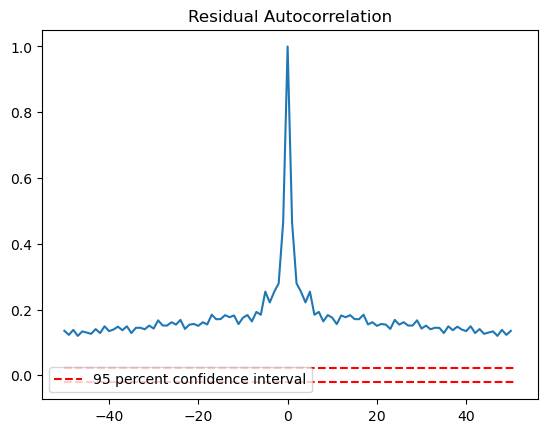

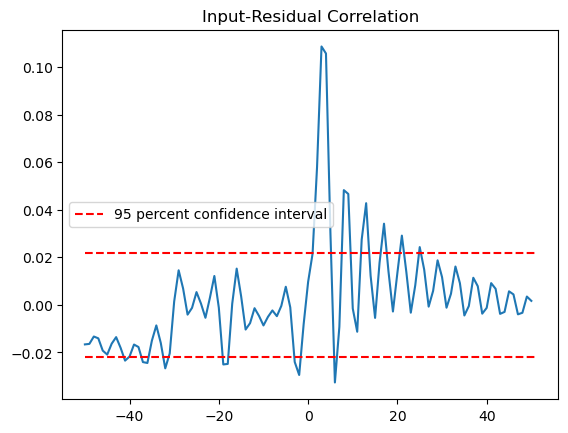

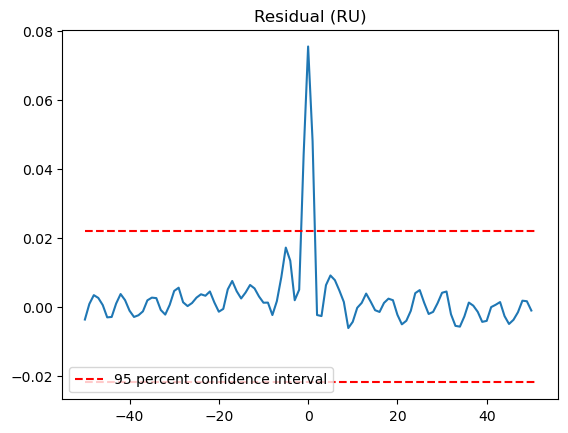

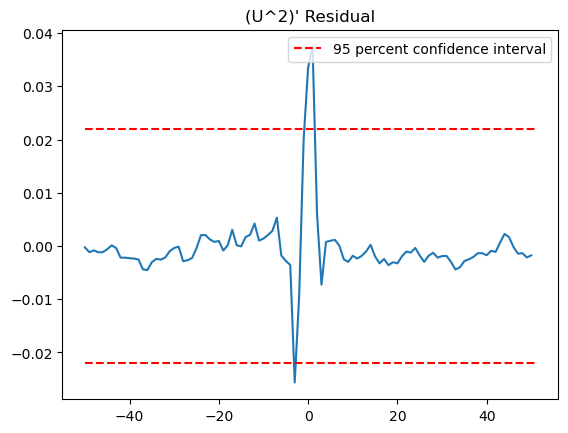

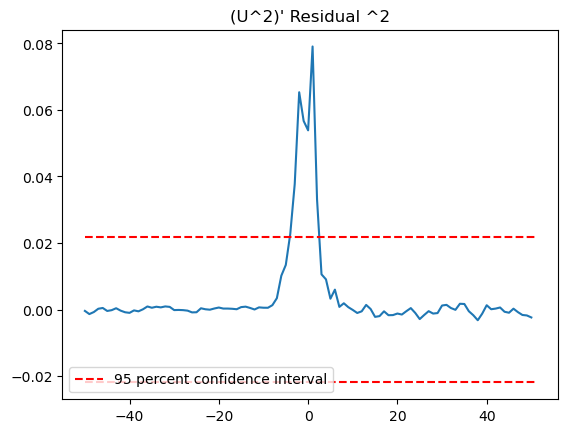

torch.Size([100, 8000])


In [21]:
sns.reset_defaults()      # resets seaborn styles
plt.rcParams.update(plt.rcParamsDefault)

def correlation(x: torch.Tensor, y: torch.Tensor, lag_max: int) -> torch.Tensor:
    '''
    Computes batched and normalized correlation between x and y [B, N] up to lag_max times
    '''
    x_centered = x - x.mean(dim=-1, keepdims=True)
    y_centered = y - y.mean(dim=-1, keepdims=True)
    cross_corrs = []
    N = x_centered.shape[1]
    assert lag_max <= N, "Lag max too long"
    x_rms = torch.sqrt((1 / N) * torch.sum(x_centered ** 2, dim=-1, keepdims=True))
    y_rms = torch.sqrt((1 / N) * torch.sum(y_centered ** 2, dim=-1, keepdims=True))
    for lag in range(-lag_max, lag_max+1):
        if lag >= 0:
            shifted_x = x_centered[:, lag:]
            shifted_y = y_centered[:, :N-lag]
        else:
            shifted_x = x_centered[:, :N+lag]
            shifted_y = y_centered[:, -lag:]

        corr = torch.mean(shifted_x * shifted_y, dim=-1, keepdims=True)
        corr_norm = torch.mean(corr / (x_rms * y_rms), dim=0) # Average across batches
        cross_corrs.append(corr_norm)
    return torch.stack(cross_corrs, dim=0)


def compute_billings_corrs(batched_residuals: torch.Tensor, batched_inputs: torch.Tensor, lag_max: int):
    '''
    Computs the Billing's et al correlation parameters to determine whether a model
    has captured the system's nonlinearity

    Args:
        batched_residuals: model errors of shape [B, N]
        batched_inputs: model inputs of shape [B, N]
    '''

    confidence_value = 1.96 / np.sqrt(batched_residuals.shape[1])
    lags = lags = np.arange(-lag_max, lag_max + 1)

    phi_r_r = correlation(batched_residuals, batched_residuals, lag_max).cpu().numpy()
    plt.plot(lags, phi_r_r)
    plt.hlines(confidence_value, -lag_max, lag_max + 1, colors='r', linestyles='dashed', label="95 percent confidence interval")
    plt.hlines(-confidence_value, -lag_max, lag_max + 1, colors='r', linestyles='dashed')
    plt.title("Residual Autocorrelation")
    plt.legend()
    plt.show()
    phi_u_r = correlation(batched_inputs, batched_residuals, lag_max).cpu().numpy()
    plt.plot(lags, phi_u_r)
    plt.hlines(confidence_value, -lag_max, lag_max + 1, colors='r', linestyles='dashed', label="95 percent confidence interval")
    plt.hlines(-confidence_value, -lag_max, lag_max + 1, colors='r', linestyles='dashed')
    plt.title("Input-Residual Correlation")
    plt.legend()
    plt.show()
    # shifted_product = batched_residuals[:, 1:] * batched_inputs[:, 1:]
    phi_r_ru = correlation(batched_residuals, batched_residuals * batched_inputs, lag_max).cpu().numpy()
    plt.plot(lags, phi_r_ru)
    plt.hlines(confidence_value, -lag_max, lag_max + 1, colors='r', linestyles='dashed', label="95 percent confidence interval")
    plt.hlines(-confidence_value, -lag_max, lag_max + 1, colors='r', linestyles='dashed')
    plt.title("Residual (RU)")
    plt.legend()
    plt.show()
    u_prime_squared = torch.square(batched_inputs) - torch.mean(batched_inputs ** 2, dim=-1, keepdim=True)
    phi_u_prime_squared_r = correlation(u_prime_squared, batched_residuals, lag_max).cpu().numpy()
    plt.plot(lags, phi_u_prime_squared_r)
    plt.hlines(confidence_value, -lag_max, lag_max + 1, colors='r', linestyles='dashed', label="95 percent confidence interval")
    plt.hlines(-confidence_value, -lag_max, lag_max + 1, colors='r', linestyles='dashed')
    plt.title("(U^2)' Residual")
    plt.legend()
    plt.show()
    phi_u_prime_squared_r_squared = correlation(u_prime_squared, batched_residuals ** 2, lag_max).cpu().numpy()
    plt.plot(lags, phi_u_prime_squared_r_squared)
    plt.hlines(confidence_value, -lag_max, lag_max + 1, colors='r', linestyles='dashed', label="95 percent confidence interval")
    plt.hlines(-confidence_value, -lag_max, lag_max + 1, colors='r', linestyles='dashed')
    plt.title("(U^2)' Residual ^2")
    plt.legend()
    plt.show()

raw_residuals = []
all_residuals = []
all_nu = []
all_std = []
all_inputs = []
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        all_inputs.append(x[:, :])
        y = y.to(device)
        y_pred_noisy, y_pred, _, _ = channel_model(x)
        # y_pred = channel_model(x)

        # Compute standardized residuals
        r = y - y_pred
        # r = r[:, 1:] - torch.tanh(channel_model.ar_tap) * r[:, :-1] - torch.tanh(channel_model.input_tap) * (x[:, 1:] - x[:, :-1])
        # r = noise_model(x, r)
        # r = whiten_residuals(channel_model, r, x)
        raw_residuals.append(r)

from statsmodels.stats.diagnostic import acorr_ljungbox

num_lags = 0
all_inputs_tensor = torch.cat(all_inputs, dim=0)[:100, :]
all_residuals_tensor = torch.cat(raw_residuals, dim=0)[:100, :]


# Ensure they are 0 mean
all_inputs_tensor -= all_inputs_tensor.mean(dim=-1, keepdim=True)
all_residuals_tensor -= all_residuals_tensor.mean(dim=-1, keepdim=True)

all_inputs_np  = all_inputs_tensor.cpu().numpy()
all_residuals_np  = all_residuals_tensor.cpu().numpy()


print(all_inputs_tensor.shape, all_residuals_tensor.shape)

ljung_box = 0
cross_corr = 0
auto_corr = 0
for i in range(all_inputs_np.shape[0]):
    input_seq = all_inputs_np[i]
    residual_seq = all_residuals_np[i]
    x = acorr_ljungbox(residual_seq, lags=[20])
    ljung_box += x['lb_pvalue'].values[0]
    cross_corr += np.correlate(input_seq, residual_seq, mode='full')
    auto_corr += np.correlate(residual_seq, residual_seq, mode='full')
ljung_box /= all_inputs_np.shape[0]
cross_corr /= all_inputs_np.shape[0]
auto_corr /= all_inputs_np.shape[0]


# Find zero-lag index
zero_index = auto_corr.shape[0] // 2

lag_window = 200
lags = np.arange(-lag_window, lag_window)

auto_window = auto_corr[-lag_window + zero_index: zero_index + lag_window]
cross_window = cross_corr[-lag_window + zero_index: zero_index + lag_window]

auto_window /= auto_corr[zero_index]
cross_window /= np.max(np.abs(cross_window)) # normalize so signal energy does not dominate

# Ljung-Box test for autocorrelation
print(f"Ljung-Box Value {ljung_box:.4f})")

print(type(all_residuals_tensor), type(all_inputs_tensor))
compute_billings_corrs(all_residuals_tensor, all_inputs_tensor, 50)

# Fit an AR(p) model to the residuals to check for whiteness
import statsmodels.api as sm

def fit_ar_p_to_batches(all_residuals_tensor, p):
    """
    residuals: torch.Tensor [B, T]
    returns: list of innovation sequences, one per batch
    """
    B, T = all_residuals_tensor.shape
    innovations_list = []
    phi_list = []

    for b in range(B):
        r = all_residuals_tensor[b].cpu().numpy()

        model = sm.tsa.ARIMA(r, order=(p, 0, 0))
        result = model.fit()

        innovations_list.append(result.resid)  # eta_t^{(b)}
        phi_list.append(result.arparams)      # AR coefficients

    return innovations_list, phi_list


from statsmodels.graphics.tsaplots import plot_acf

print(all_residuals_tensor.shape)

# innovations_list, phi_list = fit_ar_p_to_batches(all_residuals_tensor[:2, :], p=10)

# # compute_billings_corrs(torch.tensor(np.vstack(innovations_list), device=device, dtype=torch.float32), all_inputs_tensor[:2, :], lag_max=50)

# # plot Ar(p) kernels

# phi_avg = np.vstack(phi_list).mean(axis=0)
# plt.plot(phi_avg)
# plt.title("Solved AR Process Values")
# plt.show()

# phis_learned = noise_model.weights.detach().cpu().numpy()
# plt.plot(phis_learned)
# plt.title("AR Process Learned Values")
# plt.show()


In [22]:
# import numpy as np
# import sysidentpy

# # X, Y are your [B, N] arrays (inputs, outputs)
# # Example:
# # X.shape == (B, N)
# # Y.shape == (B, N)

# B, N = sent_frames_time.shape

# # Flatten batches into one long time series
# u = sent_frames_time.cpu().numpy().reshape(-1, 1).astype(float)  # input: [T, 1]
# y = received_frames_time_resampled.cpu().numpy().reshape(-1, 1).astype(float)  # output: [T, 1]
# # Simple train/validation split in time
# train_frac = 0.8
# T = u.shape[0]
# T_train = int(train_frac * T)

# x_train, x_valid = u[:T_train], u[T_train:]
# y_train, y_valid = y[:T_train], y[T_train:]


# import pandas as pd

# from sysidentpy.model_structure_selection import FROLS
# from sysidentpy.basis_function import Polynomial
# from sysidentpy.metrics import root_relative_squared_error
# from sysidentpy.utils.display_results import results

# # Max lags for dictionary (you can tune these)
# max_ylag = 5   # past outputs
# max_xlag = 5   # past inputs
# max_elag = 5   # past residuals (NARMAX part)

# basis_function = Polynomial(degree=2)

# model = FROLS(
#     ylag=max_ylag,
#     xlag=max_xlag,
#     elag=max_elag,
#     basis_function=basis_function,
#     order_selection=True,
#     info_criteria="aic",
#     n_info_values=10,
#     model_type="NARMAX",
# )

# model.fit(X=x_train, y=y_train)
# yhat_valid = model.predict(X=x_valid, y=y_valid)

# rrse = root_relative_squared_error(y_valid, yhat_valid)
# print("Validation RRSE:", rrse)

# # Table of selected regressors + parameters + ERR
# r = pd.DataFrame(
#     results(
#         model.final_model,
#         model.theta,
#         model.err,
#         model.n_terms,
#         err_precision=8,
#         dtype="sci",
#     ),
#     columns=["Regressors", "Parameters", "ERR"],
# )
# print(r)


# from sysidentpy.metrics import root_relative_squared_error

# def fit_one(ylag, xlag, elag, degree=2):
#     basis_function = Polynomial(degree=degree)
#     model = FROLS(
#         ylag=ylag,
#         xlag=xlag,
#         elag=elag,
#         basis_function=basis_function,
#         order_selection=True,
#         info_criteria="aic",
#         n_info_values=10,
#         model_type="NARMAX",
#     )
#     model.fit(X=x_train, y=y_train)
#     yhat_val = model.predict(X=x_valid, y=y_valid)
#     rrse = root_relative_squared_error(y_valid, yhat_val)
#     return model, rrse

# lag_candidates = [2, 3, 4, 5]  # you can expand this
# best_rrse = np.inf
# best_cfg = None
# best_model = None

# for ylag in lag_candidates:
#     for xlag in lag_candidates:
#         for elag in lag_candidates:
#             m, r_val = fit_one(ylag, xlag, elag)
#             print(f"ylag={ylag}, xlag={xlag}, elag={elag} -> RRSE={r_val:.4e}")
#             if r_val < best_rrse:
#                 best_rrse = r_val
#                 best_cfg = (ylag, xlag, elag)
#                 best_model = m

# print("Best config (ylag, xlag, elag):", best_cfg)
# print("Best validation RRSE:", best_rrse)


# import matplotlib.pyplot as plt

# from sysidentpy.utils.plotting import plot_results, plot_residues_correlation
# from sysidentpy.residues.residues_correlation import (
#     compute_residues_autocorrelation,
#     compute_cross_correlation,
# )

# # Predict on validation data
# yhat_valid = best_model.predict(X=x_valid, y=y_valid)

# # 4.1 Plot y vs ŷ
# plot_results(y=y_valid, yhat=yhat_valid, n=len(y_valid), figsize=(10, 4))

# # 4.2 Residual autocorrelation  φ_{ξξ}(τ)
# ee, ub_e, lb_e = compute_residues_autocorrelation(y_valid, yhat_valid)
# plot_residues_correlation(
#     data=ee,
#     title="Residual autocorrelation",
#     ylabel=r"$\phi_{\xi\xi}(\tau)$",
# )

# # 4.3 Cross-correlation residual–input φ_{ξx}(τ)
# x_val_flat = x_valid.flatten()
# x_val_flat = x_val_flat[: y_valid.shape[0]]  # ensure same length

# xe, ub_xe, lb_xe = compute_cross_correlation(y_valid, yhat_valid, x_val_flat)
# plot_residues_correlation(
#     data=xe,
#     title="Residual–input cross-correlation",
#     ylabel=r"$\phi_{\xi x}(\tau)$",
# )




In [23]:

# sns.set_theme(style="whitegrid", rc={
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Arial"],
#     "font.size": 6,
#     "axes.labelsize": 6,
#     "axes.titlesize": 6,
#     "legend.fontsize": 5,
#     "xtick.labelsize": 5,
#     "ytick.labelsize": 5,
#     "axes.linewidth": 0.5,
#     "xtick.major.width": 0.4,
#     "ytick.major.width": 0.4,
#     "figure.dpi": 300,
# })


# # ===== COMPUTE RESIDUALS FOR ALL VALIDATION SAMPLES =====
# raw_residuals = []
# all_residuals = []
# all_nu = []
# all_std = []
# all_inputs = []
# with torch.no_grad():
#     for x, y in val_loader:
#         x = x.to(device)
#         all_inputs.append(x[:, RECEPTIVE_FIELD:])
#         y = y.to(device)
#         _, mean_pred, std_pred, nu_pred = channel_model(x)

#         # Compute standardized residuals
#         residuals = (y - mean_pred) / std_pred

#         raw_r = (y - mean_pred)
#         raw_residuals.append(raw_r[:, RECEPTIVE_FIELD:])
#         all_residuals.append(residuals[:, RECEPTIVE_FIELD:])
#         all_nu.append(nu_pred[:, RECEPTIVE_FIELD:])
#         all_std.append(std_pred[:, RECEPTIVE_FIELD:])



# # Flatten everything
# num_samps = 1000000
# residuals_flat = torch.cat(all_residuals, dim=0).flatten().cpu().numpy()[:num_samps]
# nu_flat = torch.cat(all_nu, dim=0).flatten().cpu().numpy()[:num_samps]
# std_flat = torch.cat(all_std, dim=0).flatten().cpu().numpy()[:num_samps]
# all_inputs_flat = torch.cat(all_inputs, dim=0).flatten().cpu().numpy()[:num_samps]

# print(f"Residual std: {residuals_flat.std():.4f}")
# print(f"Residual mean: {residuals_flat.mean():.4f} (target: 0.0)")
# print(f"Number of residuals: {len(residuals_flat)}")
# print(f"Number of nu values: {len(nu_flat)}")

# # ===== AUTO-DETECT MODEL TYPE =====
# # If nu is all zeros or very close to zero, it's a Gaussian model
# is_student_t = not channel_model.gaussian

# if is_student_t:
#     nu_mean = nu_flat.mean()
#     nu_std = nu_flat.std()
#     nu_min = nu_flat.min()
#     nu_max = nu_flat.max()
#     theoretical_residual_var = nu_mean / (nu_mean - 2)
#     print(f"Model type: Student-t (ν: mean={nu_mean:.2f}, std={nu_std:.2f}, range=[{nu_min:.2f}, {nu_max:.2f}])")
#     print(f"Theoretical residual std: {np.sqrt(theoretical_residual_var):.4f} (for t(ν,0,1))")
# else:
#     print(f"Model type: Gaussian (ν values all near zero)")
#     print(f"Theoretical residual std: 1.0 (for N(0,1))")

# # ===== COMPREHENSIVE DIAGNOSTICS =====
# fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# # 1. Q-Q Plot
# if is_student_t:
#     # Compute PIT using matched residuals and nu values
#     pit_values = np.array([stats.t.cdf(r, nu) for r, nu in zip(residuals_flat, nu_flat)])

#     # Transform uniform to standard normal for Q-Q plot
#     transformed_residuals = stats.norm.ppf(pit_values)

#     # Remove inf values (from pit_values = 0 or 1)
#     mask = np.isfinite(transformed_residuals)
#     transformed_residuals = transformed_residuals[mask]

#     # Get Q-Q data without plotting automatically
#     (osm, osr), _ = stats.probplot(transformed_residuals, dist="norm")
#     axes[0, 0].scatter(osm, osr, s=10, alpha=0.6)

#     # Add your own y = x line
#     axes[0, 0].plot([-6, 6], [-6, 6], 'r--', label='y = x (standard normal)')
#     axes[0, 0].legend()
#     axes[0, 0].set_title('Q-Q Plot (PIT-transformed for time-varying Student-t)')
# else:
#     transformed_residuals = residuals_flat
#     (osm, osr), _ = stats.probplot(residuals_flat, dist="norm")
#     axes[0, 0].scatter(osm, osr, s=10, alpha=0.6)
#     axes[0, 0].plot([-6, 6], [-6, 6], 'r--', label='y = x (standard normal)')
#     axes[0, 0].legend()
#     axes[0, 0].set_title('Q-Q Plot vs Gaussian')

# axes[0, 0].grid(True, alpha=0.3)

# # 2. Histogram with overlaid distributions
# axes[0, 1].hist(residuals_flat, bins=100, density=True, alpha=0.7,
#                 edgecolor='black', label='Data')
# x = np.linspace(-5, 5, 200)

# # Gaussian reference
# axes[0, 1].plot(x, np.exp(-0.5*x**2)/np.sqrt(2*np.pi), 'r--', lw=1.5,
#                 alpha=0.7, label='N(0,1)')

# # Student-t reference (use mean nu for visualization)
# if is_student_t:
#     student_t_pdf = stats.t.pdf(x, nu_mean)
#     axes[0, 1].plot(x, student_t_pdf, 'g-', lw=2, label=f't(ν={nu_mean:.1f})')

# axes[0, 1].set_yscale('log')
# axes[0, 1].set_xlabel('Normalized Residual')
# axes[0, 1].set_ylabel('Density (log scale)')
# axes[0, 1].set_title('Distribution (Log Scale - Shows Tails)')
# axes[0, 1].legend()
# axes[0, 1].grid(True, alpha=0.3)

# # 3. Variance comparison
# # Compute variance per timestep across all batches
# all_residuals_tensor = torch.cat(all_residuals, dim=0)  # [N_samples, time_length]
# all_nu_tensor = torch.cat(all_nu, dim=0)  # [N_samples, time_length]
# all_std_tensor = torch.cat(all_std, dim=0)

# # Empirical variance of residuals per timestep (across batch dimension)
# var_emp_per_time = all_residuals_tensor.var(dim=0).cpu().numpy()

# # Theoretical variance per timestep
# if is_student_t:
#     # For Student-t: Var[z] = ν/(ν-2)
#     theoretical_var_per_time = (all_nu_tensor.mean(dim=0) / (all_nu_tensor.mean(dim=0) - 2)).cpu().numpy()
#     var_label = 'Theoretical ν/(ν-2)'
# else:
#     # For Gaussian: Var[z] = 1
#     theoretical_var_per_time = np.ones_like(var_emp_per_time)
#     var_label = 'Theoretical (=1.0)'

# axes[1, 0].plot(var_emp_per_time, label='Empirical Var[z]', alpha=0.7, linewidth=2)
# axes[1, 0].plot(theoretical_var_per_time, label=var_label, linestyle='--', lw=2)
# axes[1, 0].axhline(var_emp_per_time.mean(), color='blue', linestyle=':', alpha=0.5,
#                    label=f'Emp Mean: {var_emp_per_time.mean():.3f}')
# axes[1, 0].axhline(theoretical_var_per_time.mean(), color='orange', linestyle=':', alpha=0.5,
#                    label=f'Theory Mean: {theoretical_var_per_time.mean():.3f}')
# axes[1, 0].set_xlabel('Time Index')
# axes[1, 0].set_ylabel('Variance')
# axes[1, 0].set_title('Variance of Standardized Residuals: Empirical vs Theoretical')
# axes[1, 0].legend(fontsize=8)
# axes[1, 0].grid(True, alpha=0.3)

# # 4. Show nu distribution over time (only for Student-t) or scale for Gaussian
# if is_student_t:
#     nu_mean_per_time = all_nu_tensor.mean(dim=0).cpu().numpy()
#     nu_std_per_time = all_nu_tensor.std(dim=0).cpu().numpy()

#     axes[1, 1].plot(nu_mean_per_time, label='Mean ν', linewidth=2)
#     axes[1, 1].fill_between(
#         range(len(nu_mean_per_time)),
#         nu_mean_per_time - nu_std_per_time,
#         nu_mean_per_time + nu_std_per_time,
#         alpha=0.3,
#         label='±1 std'
#     )
#     axes[1, 1].set_xlabel('Time Index')
#     axes[1, 1].set_ylabel('ν (degrees of freedom)')
#     axes[1, 1].set_title('Time-Varying ν Parameter')
#     axes[1, 1].legend()
#     axes[1, 1].grid(True, alpha=0.3)
# else:
#     # For Gaussian, show the scale parameter (std) variation
#     all_std_tensor = torch.cat(all_std, dim=0)
#     std_mean_per_time = all_std_tensor.mean(dim=0).cpu().numpy()
#     std_std_per_time = all_std_tensor.std(dim=0).cpu().numpy()

#     axes[1, 1].plot(std_mean_per_time, label='Mean σ', linewidth=2)
#     axes[1, 1].fill_between(
#         range(len(std_mean_per_time)),
#         std_mean_per_time - std_std_per_time,
#         std_mean_per_time + std_std_per_time,
#         alpha=0.3,
#         label='±1 std'
#     )
#     axes[1, 1].set_xlabel('Time Index')
#     axes[1, 1].set_ylabel('σ (scale parameter)')
#     axes[1, 1].set_title('Time-Varying Scale Parameter')
#     axes[1, 1].legend()
#     axes[1, 1].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# # ===== STATISTICS =====
# skewness = stats.skew(residuals_flat)
# kurtosis = stats.kurtosis(residuals_flat)

# if is_student_t:
#     # Global KS test using PIT-transformed residuals
#     ks_stat, ks_pvalue = stats.kstest(pit_values, 'uniform')
#     test_name = "KS test (PIT, uniform)"
#     test_pvalue = ks_pvalue

#     # Theoretical kurtosis (weighted by time)
#     theoretical_kurtosis = np.mean([6/(nu-4) if nu > 4 else np.inf for nu in nu_flat])
# else:
#     _, test_pvalue = stats.shapiro(residuals_flat[:5000])
#     test_name = "Shapiro-Wilk"
#     theoretical_kurtosis = 0

# Run Point

In [24]:
# for innov in innovations_list[:1]:   # show first batche
#     plot_acf(innov, lags=10)
#     plt.title("ACF of innovations for a batch")
#     plt.show()

# innovations_tensor = torch.tensor(innovations_list, device=device, dtype=all_residuals_tensor.dtype)
# compute_billings_corrs(innovations_tensor, all_inputs_tensor[:2, :], 10)

In [25]:

import matplotlib.cm as cm
device = torch.device("mps")

t = torch.linspace(0, 1, NUM_POINTS_FRAME, device=device)


freqs = torch.arange(K_MIN, 3000)[::100]

# # Downsample frequency sweep
# freqs = KS[::200].cpu()


# print(freqs)
freq_step_hz = 10e3
freqs_hz = freqs * freq_step_hz


fig, ax = plt.subplots(figsize=(10, 10))

# Normalize by real frequency values
norm = plt.Normalize(vmin=min(freqs_hz), vmax=max(freqs_hz))
cmap = cm.get_cmap('viridis')



def loop_area(x, y):
    # x, y are 1D numpy arrays
    return np.trapz(y, x)

areas = []
for f_idx, f_hz in zip(freqs, freqs_hz):
    x = 3 * torch.sin(2 * np.pi * f_idx * t).unsqueeze(0).to(device)
    # _, y, _, _ = channel_model(x)
    y = channel_model(x)

    x = x.squeeze().cpu().numpy()[RECEPTIVE_FIELD:]
    y = y.squeeze().cpu().numpy()[RECEPTIVE_FIELD:]

    t_np = t[RECEPTIVE_FIELD:].cpu().numpy()

    ax.scatter(x, y, color=cmap(norm(f_hz)), s=0.5, alpha=0.5)
    areas.append(loop_area(t_np, y))


sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Frequency (kHz)")
tick_vals = np.linspace(min(freqs_hz), max(freqs_hz), 6)
cbar.set_ticks(tick_vals)
cbar.set_ticklabels((tick_vals / 1e3).astype(int))  # display in kHz

ax.set_title("Model Prediction for Sinusoidal Inputs at Various Frequencies")
ax.set_xlabel("Input")
ax.set_ylabel("Output")
ax.grid(True, linestyle=':')
plt.tight_layout()
plt.show()


plt.plot(freqs, areas)
plt.xlabel("Frequency (10 kHz)")
plt.ylabel("Loop Area (Memory Index)")
plt.title("Dynamic Nonlinearity vs Frequency")
plt.show()


NotImplementedError: Could not run 'aten::empty.memory_format' with arguments from the 'MPS' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::empty.memory_format' is only available for these backends: [CPU, CUDA, Meta, QuantizedCPU, QuantizedCUDA, QuantizedMeta, MkldnnCPU, SparseCPU, SparseCUDA, SparseMeta, SparseCsrCPU, SparseCsrCUDA, SparseCsrMeta, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMTIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradMeta, AutogradNestedTensor, Tracer, AutocastCPU, AutocastXPU, AutocastMPS, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen\RegisterCPU.cpp:30476 [kernel]
CUDA: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen\RegisterCUDA.cpp:44679 [kernel]
Meta: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen\RegisterMeta.cpp:26996 [kernel]
QuantizedCPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen\RegisterQuantizedCPU.cpp:954 [kernel]
QuantizedCUDA: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen\RegisterQuantizedCUDA.cpp:462 [kernel]
QuantizedMeta: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen\RegisterQuantizedMeta.cpp:108 [kernel]
MkldnnCPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen\RegisterMkldnnCPU.cpp:534 [kernel]
SparseCPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen\RegisterSparseCPU.cpp:1406 [kernel]
SparseCUDA: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen\RegisterSparseCUDA.cpp:1576 [kernel]
SparseMeta: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen\RegisterSparseMeta.cpp:290 [kernel]
SparseCsrCPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen\RegisterSparseCsrCPU.cpp:1154 [kernel]
SparseCsrCUDA: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen\RegisterSparseCsrCUDA.cpp:1290 [kernel]
SparseCsrMeta: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen\RegisterSparseCsrMeta.cpp:1068 [kernel]
BackendSelect: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen\RegisterBackendSelect.cpp:792 [kernel]
Python: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:153 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\DynamicLayer.cpp:497 [backend fallback]
Functionalize: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\FunctionalizeFallbackKernel.cpp:349 [backend fallback]
Named: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\NamedRegistrations.cpp:7 [backend fallback]
Conjugate: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\ConjugateFallback.cpp:21 [kernel]
Negative: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\NegateFallback.cpp:22 [kernel]
ZeroTensor: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\ZeroTensorFallback.cpp:90 [kernel]
ADInplaceOrView: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\VariableFallbackKernel.cpp:96 [backend fallback]
AutogradOther: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19981 [autograd kernel]
AutogradCPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19981 [autograd kernel]
AutogradCUDA: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19981 [autograd kernel]
AutogradHIP: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19981 [autograd kernel]
AutogradXLA: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19981 [autograd kernel]
AutogradMPS: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19981 [autograd kernel]
AutogradIPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19981 [autograd kernel]
AutogradXPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19981 [autograd kernel]
AutogradHPU: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19981 [autograd kernel]
AutogradVE: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19981 [autograd kernel]
AutogradLazy: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19981 [autograd kernel]
AutogradMTIA: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19981 [autograd kernel]
AutogradPrivateUse1: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19981 [autograd kernel]
AutogradPrivateUse2: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19981 [autograd kernel]
AutogradPrivateUse3: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19981 [autograd kernel]
AutogradMeta: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19981 [autograd kernel]
AutogradNestedTensor: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\VariableType_2.cpp:19981 [autograd kernel]
Tracer: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\autograd\generated\TraceType_2.cpp:17715 [kernel]
AutocastCPU: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\autocast_mode.cpp:321 [backend fallback]
AutocastXPU: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\autocast_mode.cpp:463 [backend fallback]
AutocastMPS: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\autocast_mode.cpp:209 [backend fallback]
AutocastCUDA: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\autocast_mode.cpp:165 [backend fallback]
FuncTorchBatched: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:731 [backend fallback]
BatchedNestedTensor: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\TensorWrapper.cpp:207 [backend fallback]
PythonTLSSnapshot: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:161 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\functorch\DynamicLayer.cpp:493 [backend fallback]
PreDispatch: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:165 [backend fallback]
PythonDispatcher: registered at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\core\PythonFallbackKernel.cpp:157 [backend fallback]


In [ ]:
# dc_offset = config.dc_offset


# distribution_type = "student-t" if is_student_t else "gaussian"
# save_dir = f"{run_name}_{distribution_type}_{dc_offset}"
# os.makedirs(save_dir, exist_ok=True)

# # Nature one-column figure size
# FIG_W, FIG_H = 3.46, 2.8   # inches (≈88 mm × 71 mm)
# fig, ax = plt.subplots(figsize=(FIG_W, FIG_H))

# if is_student_t:
#     pit_values = np.array([stats.t.cdf(r, nu) for r, nu in zip(residuals_flat, nu_flat)])
#     transformed = stats.norm.ppf(pit_values)
#     transformed = transformed[np.isfinite(transformed)]
#     if transformed.size == 0:
#         raise ValueError("No valid transformed residuals for Q–Q plot.")
#     (osm, osr), _ = stats.probplot(transformed, dist="norm")
#     title = "Q–Q Plot (PIT-transformed for Student-t)"
# else:
#     (osm, osr), _ = stats.probplot(residuals_flat, dist="norm")
#     title = "Q–Q Plot vs Gaussian"

# sns.scatterplot(x=osm, y=osr, s=5, color="lightblue", edgecolor=None, ax=ax, rasterized=True)

# lims = [min(osm.min(), osr.min()), max(osm.max(), osr.max())]
# ax.plot(lims, lims, "r--", lw=0.6, label="y = x", c="black")
# ax.set(xlabel="Theoretical quantiles", ylabel="Sample quantiles", title=title)
# ax.legend(frameon=False, loc="upper left")
# sns.despine(trim=True)
# plt.tight_layout()
# plt.savefig(os.path.join(save_dir, "Fig1_QQplot.pdf"), format="pdf", bbox_inches="tight")
# plt.close(fig)

# # ---------------------------------------------------------------------
# # 2️⃣ HISTOGRAM OF RESIDUALS (LOG SCALE)
# # ---------------------------------------------------------------------
# fig, ax = plt.subplots(figsize=(FIG_W, FIG_H))
# sns.histplot(residuals_flat, bins=100, stat="density", color="0.5", edgecolor="black", alpha=0.7, ax=ax)

# x = np.linspace(-5, 5, 400)
# ax.plot(x, np.exp(-0.5*x**2)/np.sqrt(2*np.pi), "r--", lw=0.6, alpha=0.8, label="N(0,1)")
# if is_student_t:
#     student_t_pdf = stats.t.pdf(x, nu_mean)
#     ax.plot(x, student_t_pdf, "g-", lw=0.8, label=f"t(ν={nu_mean:.1f})")

# ax.set_yscale("log")
# ax.set(xlabel="Normalized residual", ylabel="Density (log scale)",
#        title="Distribution (log scale – tails visible)")
# ax.legend(frameon=False)
# sns.despine(trim=True)
# plt.tight_layout()
# plt.savefig(os.path.join(save_dir, "Fig2_ResidualHistogram.pdf"), format="pdf", bbox_inches="tight")
# plt.close(fig)

# # ---------------------------------------------------------------------
# # 3️⃣ VARIANCE COMPARISON
# # ---------------------------------------------------------------------
# fig, ax = plt.subplots(figsize=(FIG_W, FIG_H))
# ax.plot(var_emp_per_time, label="Empirical Var[z]", lw=0.7)
# ax.plot(theoretical_var_per_time, "--", lw=0.7, label=var_label)
# ax.axhline(var_emp_per_time.mean(), color="blue", ls=":", lw=0.5,
#            label=f"Emp Mean {var_emp_per_time.mean():.3f}")
# ax.axhline(theoretical_var_per_time.mean(), color="orange", ls=":", lw=0.5,
#            label=f"Theory Mean {theoretical_var_per_time.mean():.3f}")

# ax.set(xlabel="Time index", ylabel="Variance",
#        title="Variance of Standardized Residuals")
# ax.legend(frameon=False)
# sns.despine(trim=True)
# plt.tight_layout()
# plt.savefig(os.path.join(save_dir, "Fig3_VarianceComparison.pdf"), format="pdf", bbox_inches="tight")
# plt.close(fig)

# # ---------------------------------------------------------------------
# # 4️⃣ TIME-VARYING ν OR σ
# # ---------------------------------------------------------------------
# fig, ax = plt.subplots(figsize=(FIG_W, FIG_H))

# if is_student_t:
#     nu_mean_per_time = all_nu_tensor.mean(dim=0).cpu().numpy()
#     nu_std_per_time  = all_nu_tensor.std(dim=0).cpu().numpy()
#     ax.plot(nu_mean_per_time, lw=0.7, label="Mean ν")
#     ax.fill_between(
#         np.arange(len(nu_mean_per_time)),
#         nu_mean_per_time - nu_std_per_time,
#         nu_mean_per_time + nu_std_per_time,
#         alpha=0.3, label="±1 SD")
#     ax.set_ylabel("ν (degrees of freedom)")
#     title = "Time-varying ν parameter"
# else:
#     std_mean_per_time = all_std_tensor.mean(dim=0).cpu().numpy()
#     std_std_per_time  = all_std_tensor.std(dim=0).cpu().numpy()
#     ax.plot(std_mean_per_time, lw=0.7, label="Mean σ")
#     ax.fill_between(
#         np.arange(len(std_mean_per_time)),
#         std_mean_per_time - std_std_per_time,
#         std_mean_per_time + std_std_per_time,
#         alpha=0.3, label="±1 SD")
#     ax.set_ylabel("σ (scale parameter)")
#     title = "Time-varying Standard Deviation"

# ax.set_xlabel("Time Index")
# ax.set_title(title)
# ax.legend(frameon=False)
# sns.despine(trim=True)
# plt.tight_layout()
# plt.savefig(os.path.join(save_dir, "Fig4_TimeVaryingParameter.pdf"), format="pdf", bbox_inches="tight")
# plt.close(fig)



In [ ]:
script_dir = os.getcwd()
config_path = os.path.join(script_dir, "..", "offline_time_channel_config.yml")
with open(config_path, "r") as f:
    hyperparams = yaml.safe_load(f)

    wandb.init(project="mldrivenpeled",
            config=hyperparams,
            tags=['autoencoder'])
    config = wandb.config
    if wandb.run.notes is None:
        wandb.run.notes = ""
    print(f"WandB run info:")
    print(f"  Name: {wandb.run.name}")
    print(f"  ID: {wandb.run.id}")
    print(f"  URL: {wandb.run.url}")
    print("Chosen hyperparameters for this session:")
    print(config)

def objective(trial, tag):
    # Sample hyperparameters
    dilation_base = trial.suggest_categorical("dilation_base", [2])
    num_taps = trial.suggest_int("num_taps", 10, 256, step=2)
    hidden_channels = trial.suggest_int("hidden_channels", 4, 64, step=8)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    nlayers = trial.suggest_categorical("nlayers", [2])

    local_config = {
        "dilation_base": dilation_base,
        "num_taps": num_taps,
        "hidden_channels": hidden_channels,
        "lr": lr,
        "epochs": 50,
        "batch_size": 16,
        "Nt": 1,
        "Nf": 599,
        "save_path": "./saved_models",
        "nlayers": nlayers,
        "weight_init": "default",
        "scheduler_type": "reduce_lr_on_plateu",
        "learn_noise": True,
        "gaussian": True
    }

    wandb.init(project="mldrivenpeled", config=local_config, reinit=True,
               tags=['autoencoder', f'{tag}', f'trial {trial.number}'], mode='online')

    channel_model = None
    optimizer = None
    scheduler = None

    try:

        channel_model = TCN_channel(
            nlayers=local_config['nlayers'],
            dilation_base=local_config['dilation_base'],
            num_taps=local_config['num_taps'],
            hidden_channels=local_config['hidden_channels'],
            learn_noise=local_config['learn_noise'],
            gaussian=True
        ).to(device)

        if channel_model.gaussian:
            loss_fn = gaussian_nll
        else:
            loss_fn = students_t_loss

        optimizer = torch.optim.Adam(
            list(channel_model.parameters()), lr=lr
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
        for epoch in range(local_config['epochs']):
            loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{local_config["epochs"]}', leave=False)
            train_loss = train(channel_model, optimizer, loss_fn, loop, scheduler, train_ABC=False)
            val_loss = val(channel_model, loss_fn, val_loader, local_config)

        return val_loss

    finally:
        wandb.finish()
        time.sleep(0.5)

        del channel_model, optimizer, scheduler, loop

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        gc.collect()

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
study_name = f"optuna_offline_channel_model_{timestamp}"
study = optuna.create_study(direction="minimize", study_name=study_name, storage="sqlite:///optuna_results.db", load_if_exists=True)
study.optimize(lambda trial: objective(trial, study_name), n_trials=50)
print("Best trial:")
print(study.best_trial.params)

In [ ]:
storage = "sqlite:///optuna_results.db"

'''

{'dilation_base': 2, 'num_taps': 18, 'hidden_channels': 36, 'lr': 0.003526635762093742, 'nlayers': 3}
'''
summaries = optuna.get_all_study_summaries(storage=storage)
for summary in summaries:
    print(f"Study name: {summary.study_name}")
    print(f"  Trial count: {summary.n_trials}")
    if summary.best_trial is not None:
        print(f"  Best value: {summary.best_trial.value}")
        print(f"  Best params: {summary.best_trial.params}")
    else:
        print("  No trials completed yet.")
    print("-" * 50)

In [ ]:
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_slice,
    plot_parallel_coordinate
)

# Step 1: Choose your study name (copy it from the summaries you printed earlier)
study_name = "optuna_offline_channel_model_20251013_142218"
storage = "sqlite:///optuna_results.db"

# Step 2: Load the study
study = optuna.load_study(study_name=study_name, storage=storage)

# Step 3: Plot using interactive Plotly charts
plot_optimization_history(study).show()
plot_param_importances(study).show()
plot_slice(study).show()
plot_parallel_coordinate(study).show()

In [ ]:
study.best_trial

In [ ]:


train_sizes = (np.linspace(0.1, 1.0, 5) * len(train_dataset)).astype(int)
train_sizes = [int(s) for s in train_sizes]

all_val_losses = []
print(f"Testing training sizes: {train_sizes}")


wandb.init()
for size in tqdm(train_sizes):
    print(f"--- Training on {size} samples ---")

    subset_indices = train_dataset.indices[:size]
    train_subset = Subset(dataset, subset_indices)

    train_loader_subset = DataLoader(train_subset, batch_size=32, shuffle=True)

    channel_model.load_state_dict(initial_model_state)
    channel_model.to(device)
    channel_model.train()

    optimizer = torch.optim.Adam(channel_model.parameters(), lr=1e-3)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    NUM_EPOCHS = 3
    for epoch in range(NUM_EPOCHS):
        loop = tqdm(train_loader_subset, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}', leave=False)
        train(channel_model, optimizer, loss_fn, loop, scheduler, train_ABC=False)
        avg_val_loss = val(channel_model, loss_fn, val_loader)
        scheduler.step(avg_val_loss)

    final_val_loss = val(channel_model, loss_fn, val_loader)
    all_val_losses.append(final_val_loss)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, all_val_losses, 'o-', linewidth=2, markersize=8)
plt.xlabel("Number of Training Samples", fontsize=12)
plt.ylabel("Final Validation Loss (log)", fontsize=12)
plt.title("Learning Curve for Channel Model", fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
# Solve for least squares FIR channel model to get estimate of
# channel delay


class ARNoiseInverter(nn.Module):
    def __init__(self, p):
        super().__init__()

        self.weights = nn.Parameter(torch.zeros(p))
        self.p = p
        self.weights_fixed = torch.zeros(p, device=device)

    def forward(self, r):
        kernel = torch.cat([-self.weights_fixed, torch.ones(1, device=device)]).view(1, 1, -1).to(device) # [B, p]
        r_padded = F.pad(r, (self.p, 0))
        out = F.conv1d(r_padded.unsqueeze(1), kernel, padding=0).squeeze(1)
        return out



x_ = sent_frames_time[:100, :100].cpu()
y_ = received_frames_time_resampled[:100, :100].cpu()

device = torch.device("cpu")
sent_frames_time = sent_frames_time.to(device)
received_frames_time_resampled = received_frames_time_resampled.to(device)
def make_toeplitz(x: torch.tensor, L):
    N = len(x)
    toeplitz = torch.zeros(N, L, device=device)
    for i in range(N):
        for j in range(L):
            if i - j >= 0: # Grab lower left
                toeplitz[i, j] = x[i - j]
    return toeplitz[L:, :]

def construct_A_and_b(x_sent, y_received, L):
    N = x_sent.size(1)
    A = torch.zeros(L, L, device=device)
    b = torch.zeros(L, device=device)
    for xi, yi in zip(x_sent, y_received):
        T = make_toeplitz(xi, L)
        yi = yi[L:]
        A += T.T @ T
        b += T.T @ yi
    return A, b

L = 10

A, b = construct_A_and_b(x_, y_, L)
h_best = torch.linalg.lstsq(A.cpu(), b.cpu()).solution


def calculate_mse(x_sent, y_received, h, L):
    """
    Calculates the Mean Squared Error for the given filter h.
    """
    B, N = x_sent.shape
    device = x_sent.device
    h = h.to(device)

    y_received = y_received[:, L:]

    # 1. Pad the input on the left with L-1 zeros.
    x_padded = F.pad(x_sent, (L - 1, 0))

    # 2. Create the indices for the Toeplitz matrices.
    i = torch.arange(N, device=device).view(N, 1)
    j = torch.arange(L, device=device).view(1, L)

    # Fixed indexing - this ensures we get the right Toeplitz structure
    indices = i + (L - 1) - j

    # Clamp indices to avoid any potential out-of-bounds access
    indices = torch.clamp(indices, 0, x_padded.shape[1] - 1)

    # 3. Create the batched Toeplitz matrix X
    X = x_padded[:, indices]


    # 5. Predict y for the entire batch using the filter h
    y_pred = X @ h
    y_pred = y_pred[:, L:]


    # 6. Calculate the MSE
    mse = F.mse_loss(y_pred, y_received)
    r = y_received - y_pred

    return mse, r



mse_value, r = calculate_mse(x_, y_, h_best, L)
print(f"Mean Squared Error: {mse_value.item()}")

plt.plot(h_best.abs().numpy())
plt.xlabel("Taps")
plt.ylabel("H Mag")
plt.show()


# compute_billings_corrs(r, sent_frames_time[:, L:], lag_max=10)

def effective_length(h, alpha=0.98):
    h = np.asarray(h)
    energy = np.square(h)
    cumu = np.cumsum(energy)
    total = cumu[-1]
    L_eff = int(np.searchsorted(cumu, alpha * total)) + 1
    return L_eff
effective_length(h_best)


# fit an approximate AR(p) noise model to residuals r
innovations_list, phi_list = fit_ar_p_to_batches(r, p=6)

# solve generalized least squares for channel + noise model

noise_model = ARNoiseInverter(2)

new_weights = torch.tensor(phi_list).mean(dim=0).to(torch.float32)
noise_model.weights_fixed = new_weights


y_whitened = noise_model(y_)
x_whitened = noise_model(x_)

A_gls, b_gls = construct_A_and_b(x_whitened, y_whitened, L)
h_gls = torch.linalg.lstsq(A_gls.cpu(), b_gls.cpu()).solution

mse_value_gls, r_gls = calculate_mse(x_, y_, h_gls, L)
print(f"GLS Mean Squared Error: {mse_value_gls.item()}")
compute_billings_corrs(r_gls.detach().cpu(), x_[:, L:].detach().cpu(), lag_max=20)

# repeat again to refine noise model
innovations_list, phi_list = fit_ar_p_to_batches(r_gls.detach().cpu(), p=6)
new_weights = torch.tensor(phi_list).mean(dim=0).to(torch.float32)
noise_model.weights_fixed = new_weights

y_whitened = noise_model(y_)
x_whitened = noise_model(x_)

A_gls, b_gls = construct_A_and_b(x_whitened, y_whitened, L)
h_gls = torch.linalg.lstsq(A_gls.cpu(), b_gls.cpu()).solution
mse_value_gls, r_gls = calculate_mse(x_, y_, h_gls, L)
print(f"Refined GLS Mean Squared Error: {mse_value_gls.item()}")
compute_billings_corrs(r_gls.detach().cpu(), x_[:, L:].detach().cpu(), lag_max=20)

In [ ]:
# Solve for least squares FIR channel model to get estimate of
# channel delay
from scipy.signal import decimate, resample_poly



class ARNoiseInverter(nn.Module):
    def __init__(self, p):
        super().__init__()

        self.weights = nn.Parameter(torch.zeros(p))
        self.p = p
        self.weights_fixed = torch.zeros(p, device=device)

    def forward(self, r):
        kernel = torch.cat([-self.weights_fixed, torch.ones(1, device=device)]).view(1, 1, -1).to(device) # [B, p]
        r_padded = F.pad(r, (self.p, 0))
        out = F.conv1d(r_padded.unsqueeze(1), kernel, padding=0).squeeze(1)
        return out


x_ = sent_frames_time[:10, :].cpu()
y_ = received_frames_time_resampled[:10, :].cpu()

# x_ = decimate(x_.numpy(), 4, axis=1, zero_phase=True)
# y_ = decimate(y_.numpy(), 4, axis=1, zero_phase=True)
# x_ = torch.tensor(x_.copy(), dtype=torch.float32)
# y_ = torch.tensor(y_.copy(), dtype=torch.float32)


# x_ = resample_poly(x_.numpy(), up=1, down=6, axis=1)
# y_ = resample_poly(y_.numpy(), up=1, down=6, axis=1)
# x_ = torch.tensor(x_.copy(), dtype=torch.float32)
# y_ = torch.tensor(y_.copy(), dtype=torch.float32)

device = torch.device("cpu")

def make_toeplitz(x: torch.tensor, L):
    N = len(x)
    toeplitz = torch.zeros(N, L, device=device)
    for i in range(N):
        for j in range(L):
            if i - j >= 0: # Grab lower left
                toeplitz[i, j] = x[i - j]
    return toeplitz[L:, :]

def construct_A_and_b(x_sent, y_received, L):
    N = x_sent.size(1)
    A = torch.zeros(L, L, device=device)
    b = torch.zeros(L, device=device)
    for xi, yi in zip(x_sent, y_received):
        T = make_toeplitz(xi, L)
        yi = yi[L:]
        A += T.T @ T
        b += T.T @ yi
    return A, b

L = 10
AR_TAPS = 3
print("new shapes", x_.shape, y_.shape)
A, b = construct_A_and_b(x_, y_, L)
h_best = torch.linalg.lstsq(A.cpu(), b.cpu()).solution


def calculate_mse(x_sent, y_received, h, L):
    """
    Calculates the Mean Squared Error for the given filter h.
    """
    B, N = x_sent.shape
    device = x_sent.device
    h = h.to(device)

    y_received = y_received[:, L:]

    # 1. Pad the input on the left with L-1 zeros.
    x_padded = F.pad(x_sent, (L - 1, 0))

    # 2. Create the indices for the Toeplitz matrices.
    i = torch.arange(N, device=device).view(N, 1)
    j = torch.arange(L, device=device).view(1, L)

    # Fixed indexing - this ensures we get the right Toeplitz structure
    indices = i + (L - 1) - j

    # Clamp indices to avoid any potential out-of-bounds access
    indices = torch.clamp(indices, 0, x_padded.shape[1] - 1)

    # 3. Create the batched Toeplitz matrix X
    X = x_padded[:, indices]


    # 5. Predict y for the entire batch using the filter h
    y_pred = X @ h
    y_pred = y_pred[:, L:]


    # 6. Calculate the MSE
    mse = F.mse_loss(y_pred, y_received)
    r = y_received - y_pred

    return mse, r

# Estimate the noise covariance from residuals
mse_value, r = calculate_mse(x_, y_, h_best, L)
innovations_list, phi_list = fit_ar_p_to_batches(r, p=AR_TAPS)
rho = torch.tensor(phi_list).mean(dim=0).to(torch.float32)

noise_model = ARNoiseInverter(AR_TAPS)
noise_model.weights_fixed = torch.tensor(phi_list).mean(dim=0).to(torch.float32).to(device)
y_whitened = noise_model(y_)
x_whitened = noise_model(x_)

# idx = torch.arange(x_.shape[1])
# diff = idx[None, :] - idx[:, None]
# cov_matrix = rho ** diff.abs()
# near_zero = cov_matrix < 1e-6
# cov_matrix[near_zero] = 0.0

# S = torch.linalg.cholesky(cov_matrix)
# S_inv = torch.linalg.inv(S)





A, b = construct_A_and_b(x_whitened, y_whitened, L)
h_best = torch.linalg.lstsq(A.cpu(), b.cpu()).solution

mse_value, r = calculate_mse(x_whitened, y_whitened, h_best, L)
print(f"Mean Squared Error with noise covariance: {mse_value.item()}")

In [ ]:
compute_billings_corrs(r.detach().cpu(), x_[:, L:].detach().cpu(), lag_max=4)

innovations_list, phi_list = fit_ar_p_to_batches(r, p=3)

new_weights = torch.tensor(phi_list).mean(dim=0).to(torch.float32)
plt.plot(new_weights.numpy())
plt.xlabel("AR taps")
plt.ylabel("Coefficient value")
plt.show()

In [ ]:
torch.tensor(phi_list).mean(dim=0).to(torch.float32).to(device)


In [ ]:
t = torch.linspace(0, 1, NUM_POINTS_FRAME)


freqs = torch.arange(K_MIN, 3000)[::100]

# # Downsample frequency sweep
# freqs = KS[::200].cpu()


# print(freqs)
freq_step_hz = 10e3
freqs_hz = freqs * freq_step_hz


fig, ax = plt.subplots(figsize=(10, 10))

# Normalize by real frequency values
norm = plt.Normalize(vmin=min(freqs_hz), vmax=max(freqs_hz))
cmap = cm.get_cmap('viridis')



def loop_area(x, y):
    # x, y are 1D numpy arrays
    return np.trapz(y, x)

areas = []
normalized_rms_diffs = []
normalized_sup_errors = []
for f_idx, f_hz in zip(freqs, freqs_hz):
    phi = np.pi / 2
    x = 3 * torch.sin(2 * np.pi * f_idx * t).unsqueeze(0).to(device)
    x2 = 3 * torch.sin(2 * np.pi * f_idx * t + phi).unsqueeze(0).to(device)
    x12 = x + x2
    x_padded = F.pad(x, (L - 1, 0))
    N = x.size(1)

    i = torch.arange(N, device=device).view(N, 1)
    j = torch.arange(L, device=device).view(1, L)
    indices = i + (L - 1) - j
    indices = torch.clamp(indices, 0, x_padded.shape[1] - 1)
    X = x_padded[:, indices]
    y = X @ h_best.to(device)
    y = y[:, L:]
    x = x[:, L:]
    x2 = x2[:, L:]
    x12 = x12[:, L:]
    rms = torch.sqrt(torch.mean(y**2))
    y_nonlinear = channel_model(x)
    y12 = channel_model(x12)
    y2 = channel_model(x2)
    sup_error = torch.sqrt(torch.mean((y12 - (y + y2))**2))
    sup_norm = sup_error / torch.sqrt(torch.mean(y12**2))
    normalized_sup_errors.append(sup_norm.abs().mean().item())
    rms_diff = torch.sqrt(torch.mean((y_nonlinear - y)**2))
    normalized_diff = rms_diff / rms
    normalized_rms_diffs.append(normalized_diff.abs().mean().item())


    t_np = t[L:].cpu().numpy()


    x = x.squeeze().cpu().numpy()
    y = y.squeeze().cpu().numpy()

    ax.scatter(x, y, color=cmap(norm(f_hz)), s=0.5, alpha=0.5)
    areas.append(loop_area(x, y))


sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Frequency (kHz)")
tick_vals = np.linspace(min(freqs_hz), max(freqs_hz), 6)
cbar.set_ticks(tick_vals)
cbar.set_ticklabels((tick_vals / 1e3).astype(int))  # display in kHz

ax.set_title("Model Prediction for Sinusoidal Inputs at Various Frequencies")
ax.set_xlabel("Input")
ax.set_ylabel("Output")
ax.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

plt.plot(freqs, normalized_rms_diffs)
plt.xlabel("Frequency (10 kHz)")
plt.ylabel("Normalized Mean RMS Difference from Linear Model")
plt.title("Nonlinearity Magnitude vs Frequency")
plt.show()

plt.plot(freqs, normalized_sup_errors)
plt.xlabel("Frequency (10 kHz)")
plt.ylabel("Normalized Sup Error from Linear Model")
plt.title("Nonlinearity Sup Error vs Frequency")
plt.show()
